# Testando Modelos Locais

Antes de definirmos qual modelo utilizar em nosso software, decidimos, como primeiro passo, testar modelos open-source disponíveis. O objetivo foi compreender melhor a dinâmica desses modelos e sua aplicabilidade em diferentes cenários. Para isso, criamos um benchmark abrangente, avaliando uma série de modelos com diferentes quantidades de parâmetros, tipos de questões e analisando seu desempenho em diversas disciplinas.

In [28]:
from IPython.display import display, clear_output
import os

if "notebooks" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join(os.getcwd(), "..")))

import lib.utils
from lib.utils import plots
from lib.models_help.runner import test_models

import random
random.seed(42)

import warnings
warnings.filterwarnings("ignore")

questoes = lib.utils.load_json("./data/questoes/questoes.json")

## 1. Modelos

Inicialmente, exploramos modelos disponíveis no [Ollama](https://ollama.com/), um repositório de LLMs similar ao Hugging Face, mas que permite uma facilidade no download e interface de comunicação com as LLMs. Optamos por baixar localmente **20 modelos**, variando em quantidade de parâmetros e especialização, incluindo modelos com capacidade maior de auto-avaliação ou raciocínio (*reasoning*), multi-modais (*vision*), matemática (*math*) e modelos mais comuns limitados a apenas texto (*text*).

Ao selecionar os modelos, consideramos uma limitação fundamental: o **tamanho máximo de 14 GB**. Como o objetivo é emular um produto destinado a **clientes** e não a servidores de alta performance, priorizamos modelos compactos que possam ser **executados em dispositivos locais**, sem depender de infraestrutura robusta. Vale lembrar que **o tamanho de um modelo não se resume ao espaço ocupado pelos arquivos armazenados**, mas também ao consumo de memória durante a execução, sendo carregado integralmente na RAM e/ou VRAM do dispositivo do usuário.

Abaixo, apresentamos uma análise da relação entre a quantidade de parâmetros (em bilhões) e o tamanho dos modelos (em GB).


| #   | Modelo            | Parâmetros                                   | Tamanho (Em GB)               | Algoritmo   |
|-----|-------------------|----------------------------------------------|-------------------------------|-------------|
| 1   | deepseek-r1       | `7.0`                                        | `7.0`                         | reasoning   |
| 2   | deepscaler        | `1.5`                                        | `3.6`                         | reasoning   |
| 3   | gemma2            | `9.0`                                        | `5.4`                         | text        |
| 4   | llava             | `7.0`                                        | `4.7`                         | vision      |
| 5   | llava-llama3      | `8.0`                                        | `5.5`                         | vision      |
| 6   | llava-phi3        | `3.8`                                        | `2.9`                         | vision      |
| 7   | llama3.2          | `3.0`                                        | `2.0`                         | text        |
| 8   | llama3.2-vision   | `11.0`                                       | `7.9`                         | vision      |
| 9   | mathstral         | `7.0`                                        | `4.1`                         | math        |
| 10  | minicpm-v         | `8.0`                                        | `5.5`                         | vision      |
| 11  | mistral           | `7.0`                                        | `4.1`                         | text        |
| 12  | mistral-nemo      | `12.0`                                       | `7.1`                         | reasoning   |
| 13  | mistral-small     | `24.0`                                       | `14.0`                        | text        |
| 14  | moondream         | `1.8`                                        | `1.7`                         | vision      |
| 15  | openthinker       | `7.0`                                        | `4.7`                         | reasoning   |
| 16  | phi3.5            | `3.8`                                        | `2.2`                         | reasoning   |
| 17  | phi4              | `14.0`                                       | `9.1`                         | text        |
| 18  | qwen2-math        | `7.0`, `1.5`                                 | `4.4`, `0.934`                | math        |
| 19  | qwen2.5           | `14.0`, `7.0`, `1.5`                         | `9.0`, `4.7`, `0.986`         | text        |
| 20  | smallthinker      | `3.0`                                        | `3.6`                         | reasoning   |


A imagem abaixo ilustra a correlação entre o número de parâmetros (em bilhões) e o tamanho dos modelos (em GB):

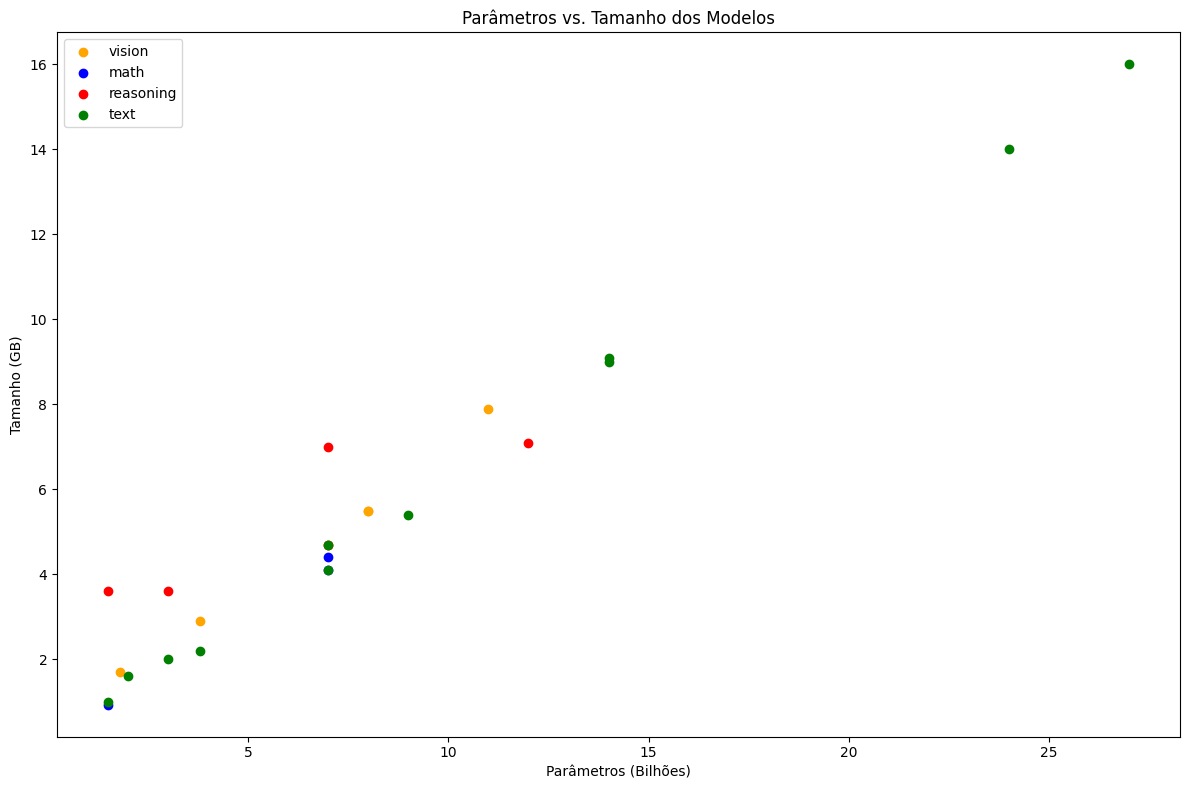

In [29]:
lib.utils.models_info.plot_parameters_x_size()
None

Observamos que, de maneira geral, **a relação entre a quantidade de parâmetros e o tamanho do modelo segue um padrão bastante linear**. No entanto, há algumas diferenças dependendo do tipo de modelo:  

- **Modelos de reasoning** tendem a ser **ligeiramente maiores** do que outros modelos com a mesma quantidade de parâmetros.  
- **Modelos de visão computacional (vision)** também apresentam um **aumento sutil no tamanho**, possivelmente devido às camadas especializadas para processamento de imagens.  

Essa análise inicial nos permite compreender melhor as exigências de cada modelo em termos de armazenamento e memória, ajudando na escolha da melhor opção para diferentes aplicações locais.

## 2. Questões de Texto  

O primeiro tipo de questão que vamos analisar são as **questões de texto**, que representam **63,6%** de todas as questões do dataset. Para avaliar o desempenho dos modelos nesse tipo de tarefa, dividimos os testes em **três grupos distintos**:  

1. **Modelos com diferentes versões de tokens** – investigamos o impacto do tamanho do modelo no desempenho, comparando versões de um mesmo modelo com quantidades variadas de tokens.  
2. **Modelos com suporte a reasoning** – testamos modelos projetados para raciocínio avançado, que, apesar de mais lentos, prometem um processamento mais elaborado e preciso.  
3. **Demais modelos baseados apenas em texto** – avaliamos modelos que lidam exclusivamente com entrada textual, sem otimizações específicas para reasoning.  

Para conduzir esse experimento, selecionamos **100 questões de forma pseudo-aleatória**, garantindo uma distribuição balanceada com **25 questões de cada disciplina**. Dessa forma, buscamos assegurar que os resultados reflitam de maneira justa a capacidade dos modelos em interpretar e responder diferentes tipos de perguntas textuais.  


In [30]:
# Realizamos uma filtragem nas questões para obtermos apenas as questões com apenas texto
text_questions   = list(filter(lambda x : x["type"] == "only-text", questoes))

# Agora seelcionamos de forma pseudo-aleatória as 100 questões, sendo 25 de cada disciplina
example_text_questions  = (
    list(random.sample(list(filter(lambda x : x["discipline"] == "ciencias-humanas", text_questions)), 25)) +
    list(random.sample(list(filter(lambda x : x["discipline"] == "ciencias-natureza", text_questions)),25)) +
    list(random.sample(list(filter(lambda x : x["discipline"] == "linguagens", text_questions)),25)) +
    list(random.sample(list(filter(lambda x : x["discipline"] == "matematica", text_questions)),25))
)

### 2.1 Avaliando o Impacto do Tamanho do Modelo  

Para esse teste, utilizaremos **dois modelos principais**:  

- **Qwen2.5**, nas versões:  
  - `14b` (9.0GB)  
  - `7b` (4.7GB)  
  - `1.5b` (1.9GB)  

- **Gemma2**, nas versões:  
  - `27b` (16GB)  
  - `9b` (5.4GB)  
  - `2b` (1.6GB)  

Escolhemos esses dois modelos porque, entre os selecionados, são os que oferecem **maior diversidade de quantidade de parâmetros**, permitindo uma análise mais abrangente. Além disso, eles apresentam uma variação de tamanho que cobre desde **modelos extremamente compactos** (menos de 2GB, ideais para sistemas embarcados) até **modelos mais convencionais** (`7b` e `9b`), além de **opções mais robustas**, como o `14b` e `27b`.  

Para esse experimento, utilizaremos o mesmo **conjunto de questões selecionadas de forma pseudo-aleatória**, já descrito anteriormente. Avaliaremos:  

- **Métricas de desempenho**, incluindo número de acertos e erros, tanto no geral quanto por disciplina.  
- **Comparação entre os dois modelos**, buscando identificar **tendências de eficiência** em relação à quantidade de parâmetros.  

Nosso objetivo final é tentar inferir **até que ponto o aumento no número de parâmetros impacta o desempenho** e se há um ponto de equilíbrio entre **qualidade da resposta e eficiência computacional**.  


#### 2.1.1 - Qwen2.5  

Nosso primeiro alvo de análise é o **Qwen 2.5**, avaliando seu desempenho em diferentes tamanhos e identificando padrões de comportamento.  

##### **Acurácia dos Modelos**  

Ao analisarmos a **acurácia**, percebemos que **o número de acertos se manteve estável** entre o modelo mais robusto e o modelo intermediário. No entanto, ao compararmos com a versão mais leve, observamos uma **queda significativa**, reduzindo-se para **menos da metade** da acurácia dos demais modelos.  

##### **Tempo de Execução**  

O mesmo padrão foi identificado em relação ao **tempo de execução**. O modelo intermediário apresentou **tempos máximos semelhantes ao modelo maior**, enquanto o modelo mais leve teve uma redução proporcional no tempo de inferência. Além disso, ao analisarmos os tempos médios, identificamos uma **relação linear entre a quantidade de parâmetros e o tempo de execução** – quanto menor o número de parâmetros, menor tende a ser o tempo necessário para processar uma resposta.  

##### **Desempenho por Disciplina**  

Ao compararmos o desempenho por disciplina, observamos que a **diferença entre o modelo intermediário e o modelo maior foi mínima**, exceto por um leve aumento na acurácia em **ciências humanas** no modelo maior. Em **matemática**, ambos os modelos apresentaram **o mesmo desempenho**, sem vantagens claras entre eles.  

Um padrão recorrente em **todos os tamanhos do Qwen 2.5** foi a **baixa acurácia em questões matemáticas**, o que sugere uma limitação específica do modelo nessa área. Esse comportamento também foi observado em outros modelos, indicando que pode ser uma característica comum entre os LLMs testados.  

##### **Visualização dos Resultados**  

Os gráficos abaixo ilustram esses padrões. Caso esteja acessando via plataforma interativa, você pode **selecionar os modelos e o tipo de gráfico** para comparação personalizada.


,Model,Size,Finish,OK,Null,Tout,Err,Acc,Prec,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,qwen2.5:14b,9.0,100 (33.3%),64,2,0,34,0.640000,0.653061,01:12,01:12,0.00,0.72,4.78,0.30
1,qwen2.5:7b,4.7,100 (33.3%),64,0,0,36,0.640000,0.640000,33.26,33.26,0.00,0.33,4.68,0.15
2,qwen2.5:1.5b,1.0,100 (33.3%),42,0,0,58,0.420000,0.420000,15.78,15.78,0.00,0.16,2.12,0.07
3,TOTAL,14.7,300 (33.3%),170,2,0,128,0.566667,0.570470,02:01,02:01,0.00,0.40,4.78,0.07


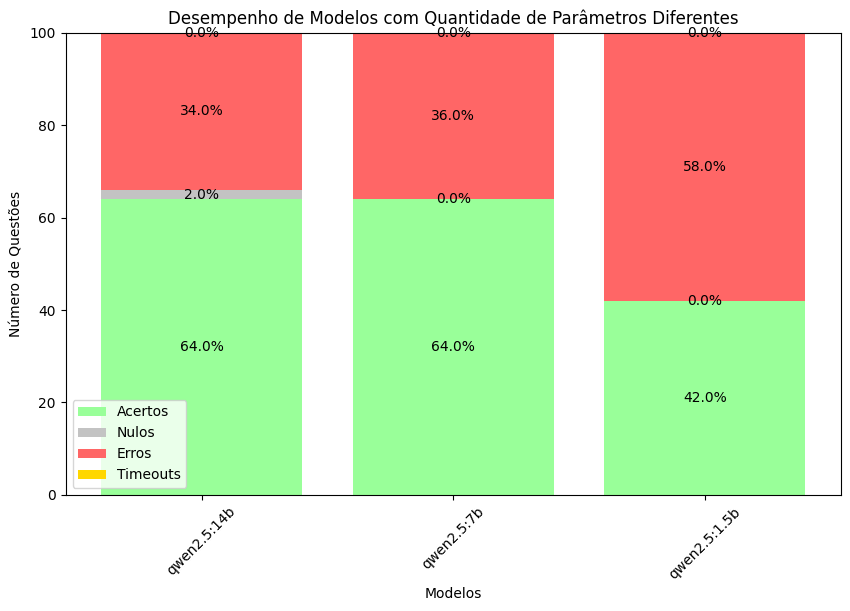

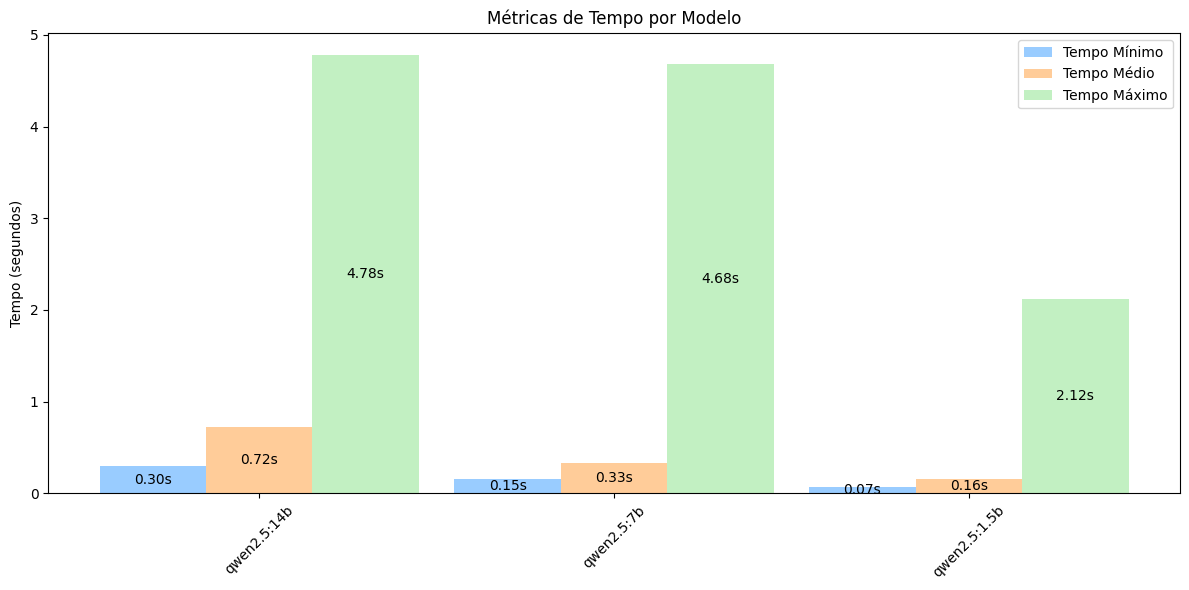

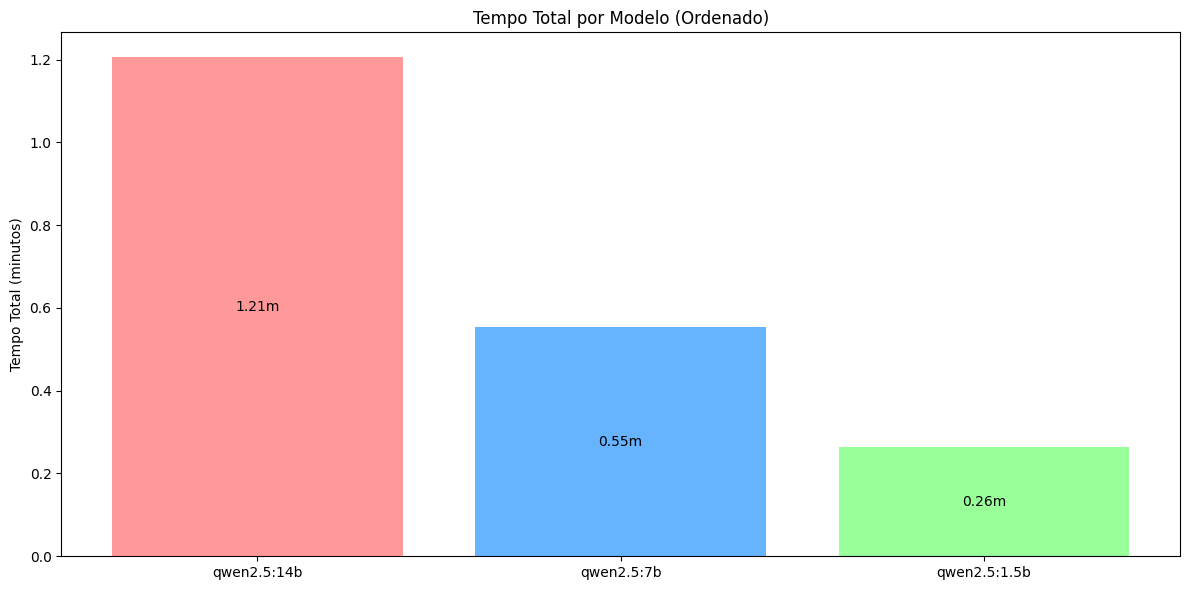

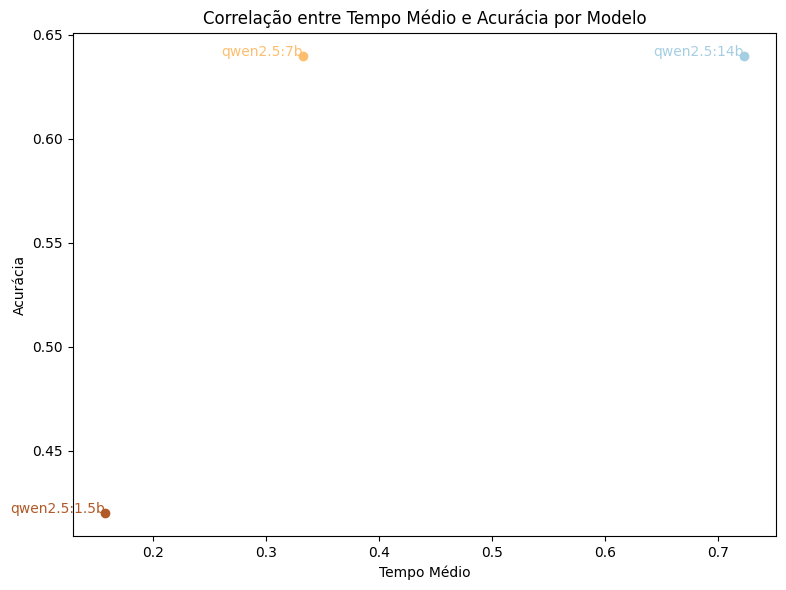

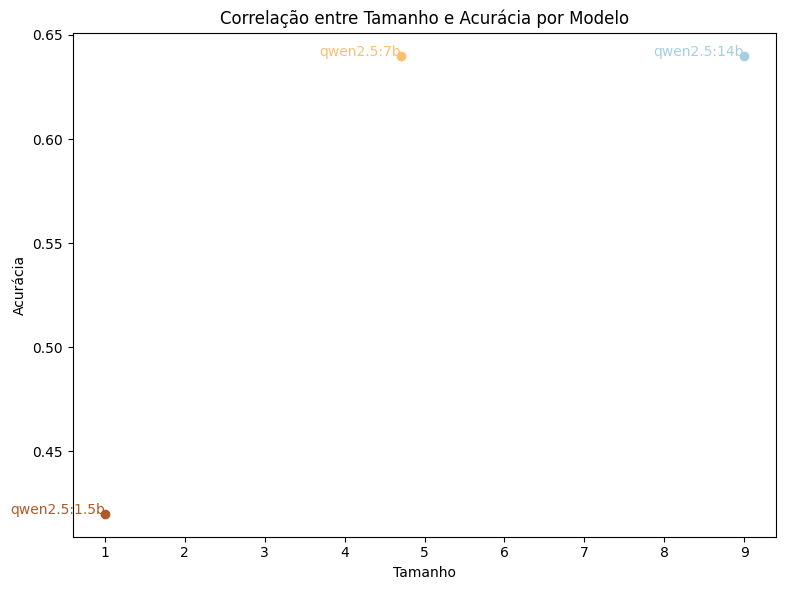

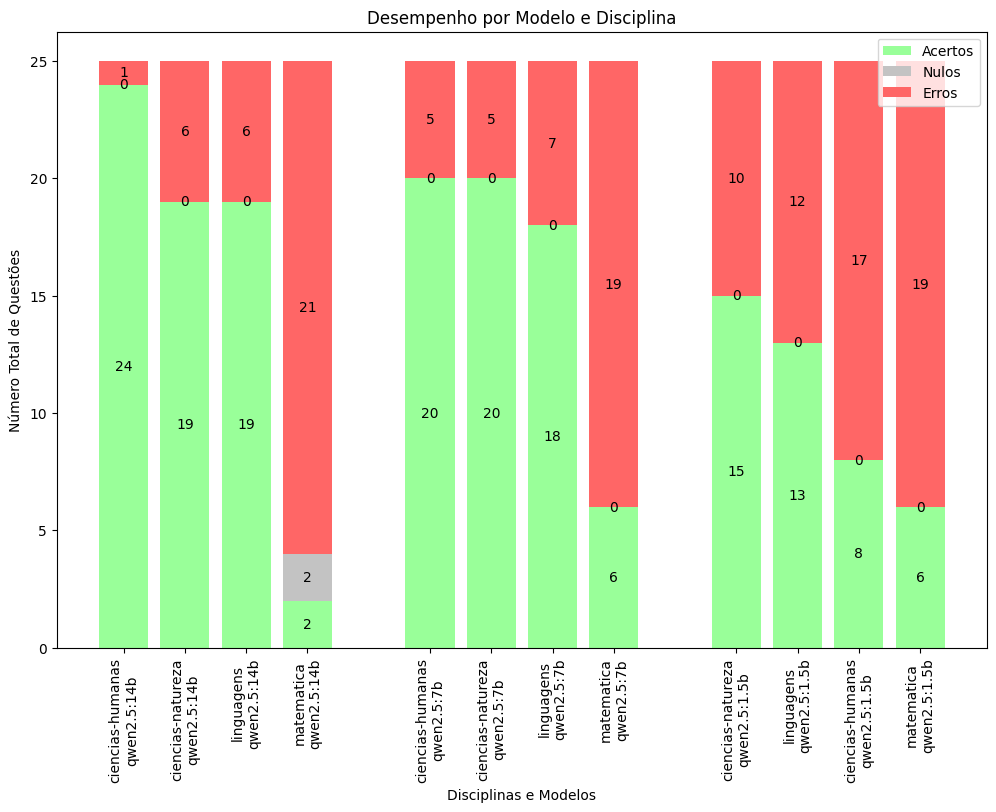

In [31]:
qwen_models = ["qwen2.5:14b", "qwen2.5:7b", "qwen2.5:1.5b"]

test_result = test_models(
    primary_models=qwen_models,
    questions=example_text_questions
)

qwen_table = lib.utils.test_table(
    questions=example_text_questions,
    models=qwen_models
)

clear_output(wait=True)
display(lib.utils.format_test_table(qwen_table))
plots.model_performance(qwen_table, "Desempenho de Modelos com Quantidade de Parâmetros Diferentes")
plots.time_metrics(qwen_table)
plots.time_metrics_total(qwen_table)
plots.correlation(qwen_table)
plots.correlation(qwen_table, "Size")
plots.discipline_performance(qwen_models, example_text_questions, True, False)
None

#### 2.1.3 - Gemma2  

Nesta seção, analisamos o desempenho do modelo **Gemma2** em diferentes configurações de tamanho, a fim de identificar padrões de comportamento e avaliar sua eficiência em relação à acurácia e ao tempo de execução.  

##### **Acurácia dos Modelos**  

A análise da **acurácia** revelou que, de maneira similar aos modelos **Qwen2.5**, a quantidade de acertos obtida pelo modelo mais robusto e pelo modelo intermediário permaneceu praticamente inalterada. No entanto, ao comparar com o modelo de menor porte, observou-se uma redução no número de respostas corretas.  

Diferentemente do que foi constatado no **Qwen2.5**, a perda de desempenho no modelo mais leve do **Gemma2** foi **menos acentuada**. A diferença observada foi de **apenas 10 respostas corretas a menos em relação ao modelo intermediário**, representando uma das melhores relações entre **desempenho e tamanho do modelo** entre os modelos avaliados.  

##### **Tempo de Execução**  

Em relação ao **tempo de inferência**, os resultados obtidos não seguiram a correlação linear observada em outros modelos. O **modelo intermediário apresentou o menor tempo médio e mínimo de execução**, o que diverge da expectativa de um comportamento proporcional ao número de parâmetros. Esse fenômeno sugere que o **Gemma2 pode possuir otimizações internas**, que resultam em um melhor aproveitamento computacional em determinados tamanhos.  

##### **Desempenho por Disciplina**  

A análise do desempenho por disciplina revelou uma **intercalação entre os modelos quanto à sua eficácia em diferentes áreas do conhecimento**:  

- **Ciências humanas** – Desempenho equivalente entre os modelos maiores, o menor ainda sim conseguiu uma quantidade de acertos aceitáveis, variando em apenas 2 questões.  
- **Ciências naturais e matemática** – O modelo mais robusto apresentou um desempenho superior, com um aumento de **3 e 2 respostas corretas**, respectivamente.  
- **Linguagens** – O modelo intermediário superou o modelo mais robusto, obtendo **4 respostas corretas adicionais**.  

Embora a **acurácia geral tenha se mantido semelhante entre os modelos**, a análise segmentada por disciplina evidencia que **o desempenho dos modelos não é uniforme** e pode variar conforme o domínio da questão analisada.  

##### **Desempenho em Matemática**  

O padrão de **baixo desempenho em matemática** também foi identificado no modelo **Gemma2**, confirmando a tendência observada em outros modelos. Especificamente, os resultados foram:  

- **Modelo robusto** – 7 acertos  
- **Modelo intermediário** – 5 acertos  
- **Modelo leve** – 4 acertos  

Independentemente da configuração utilizada, o desempenho em matemática manteve-se reduzido, o que sugere uma **limitação inerente ao modelo** no processamento desse tipo específico de questão.  

##### **Visualização dos Resultados**  

As informações detalhadas podem ser observadas nos gráficos apresentados a seguir. Além disso, caso o leitor esteja acessando por meio da plataforma interativa, é possível **selecionar os modelos e o tipo de gráfico desejado** para uma análise comparativa personalizada.  


,Model,Size,Finish,OK,Null,Tout,Err,Acc,Prec,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,gemma2:27b,16.0,100 (33.3%),69,1,0,30,0.69,0.696970,12:08,12:08,0.00,7.29,01:20,5.78
1,gemma2,5.4,100 (33.3%),68,1,0,31,0.68,0.686869,58.63,58.63,0.00,0.59,8.83,0.28
2,gemma2:2b,1.6,100 (33.3%),58,0,0,42,0.58,0.580000,06:32,06:32,0.00,3.93,6.44,3.59
3,TOTAL,23.0,300 (33.3%),195,2,0,103,0.65,0.654362,19:40,19:40,0.00,3.93,01:20,0.28


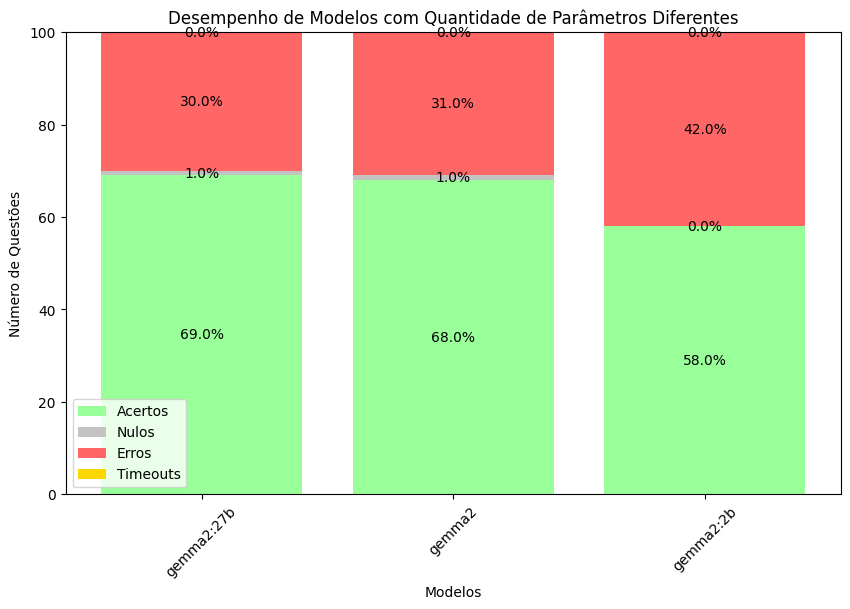

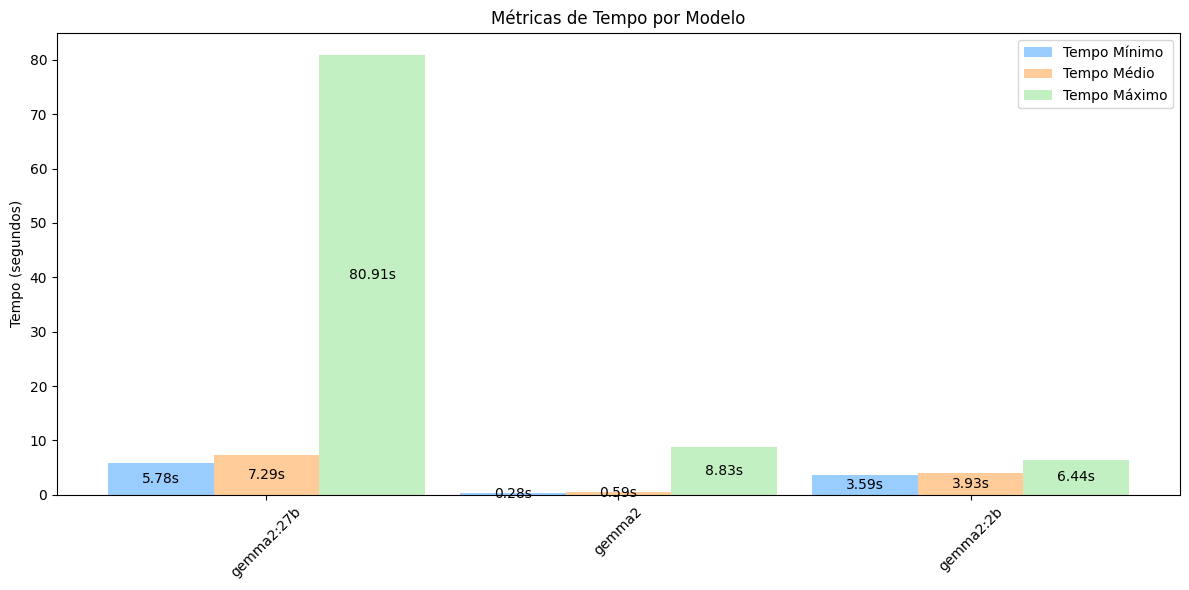

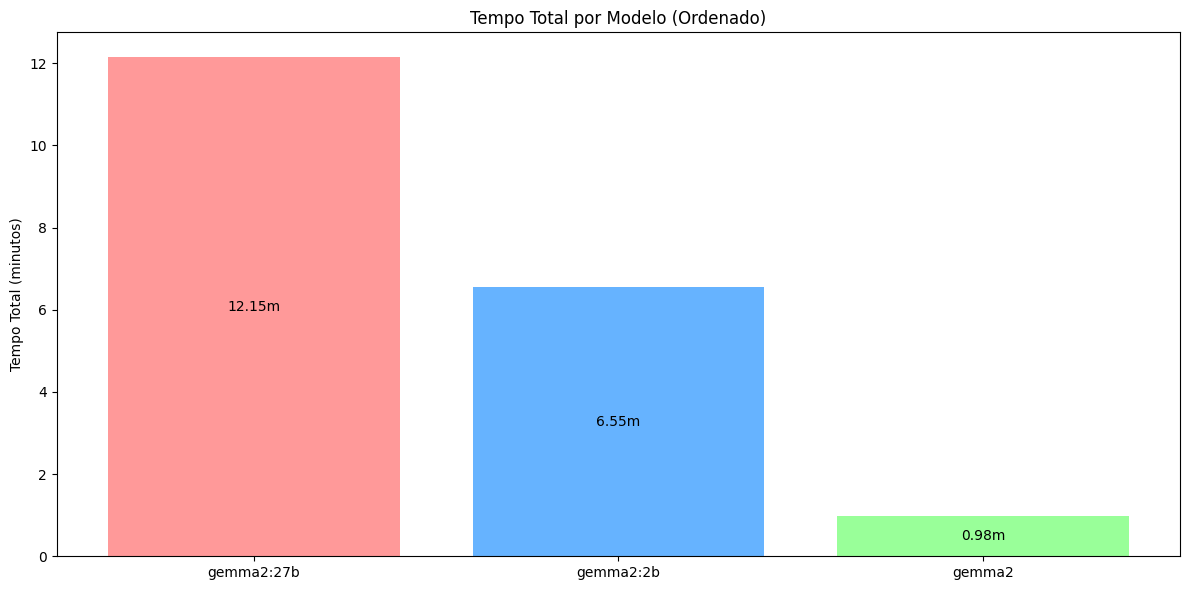

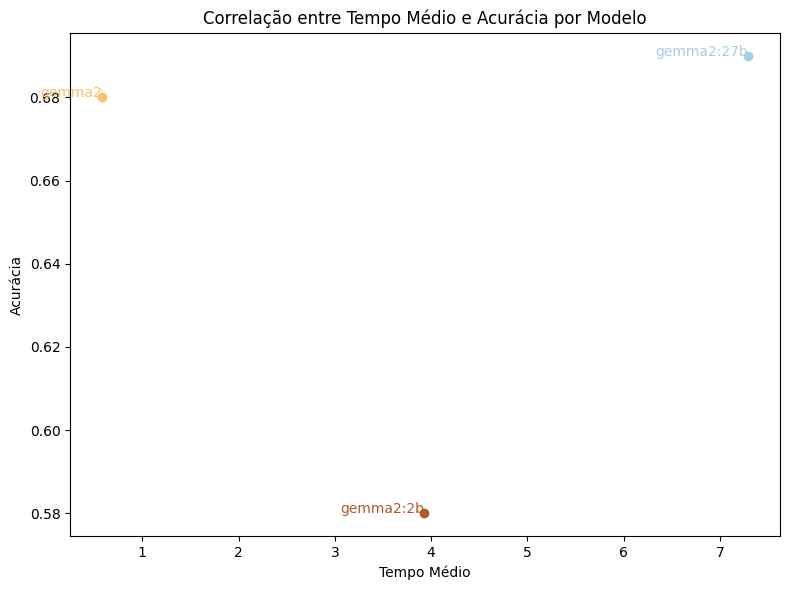

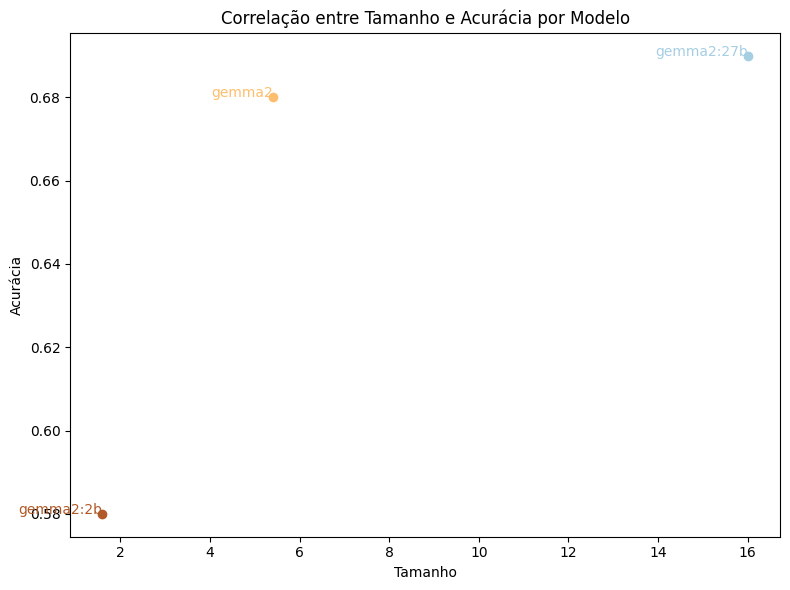

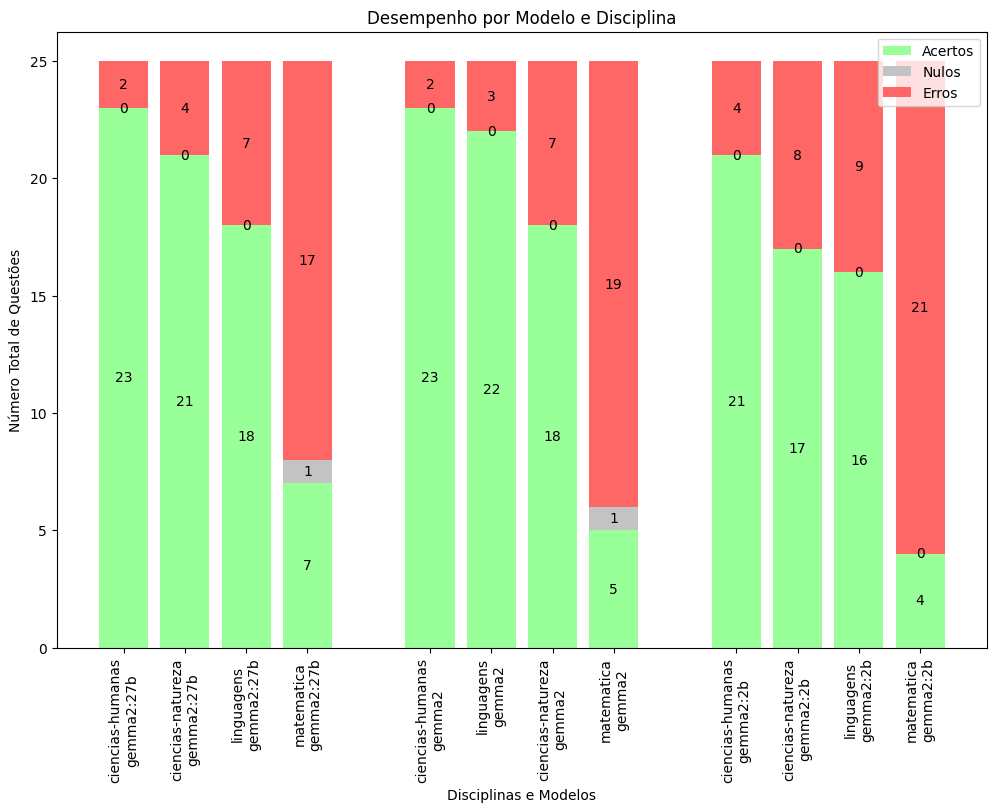

In [32]:
gemma_models = ["gemma2:2b", "gemma2", "gemma2:27b"]

test_result = test_models(
    primary_models=gemma_models,
    questions=example_text_questions
)

gemma_table = lib.utils.test_table(
    questions=example_text_questions,
    models=gemma_models
)

clear_output(wait=True)
display(lib.utils.format_test_table(gemma_table))
plots.model_performance(gemma_table, "Desempenho de Modelos com Quantidade de Parâmetros Diferentes")
plots.time_metrics(gemma_table)
plots.time_metrics_total(gemma_table)
plots.correlation(gemma_table)
plots.correlation(gemma_table, "Size")
plots.discipline_performance(gemma_models, example_text_questions, True, False)
None

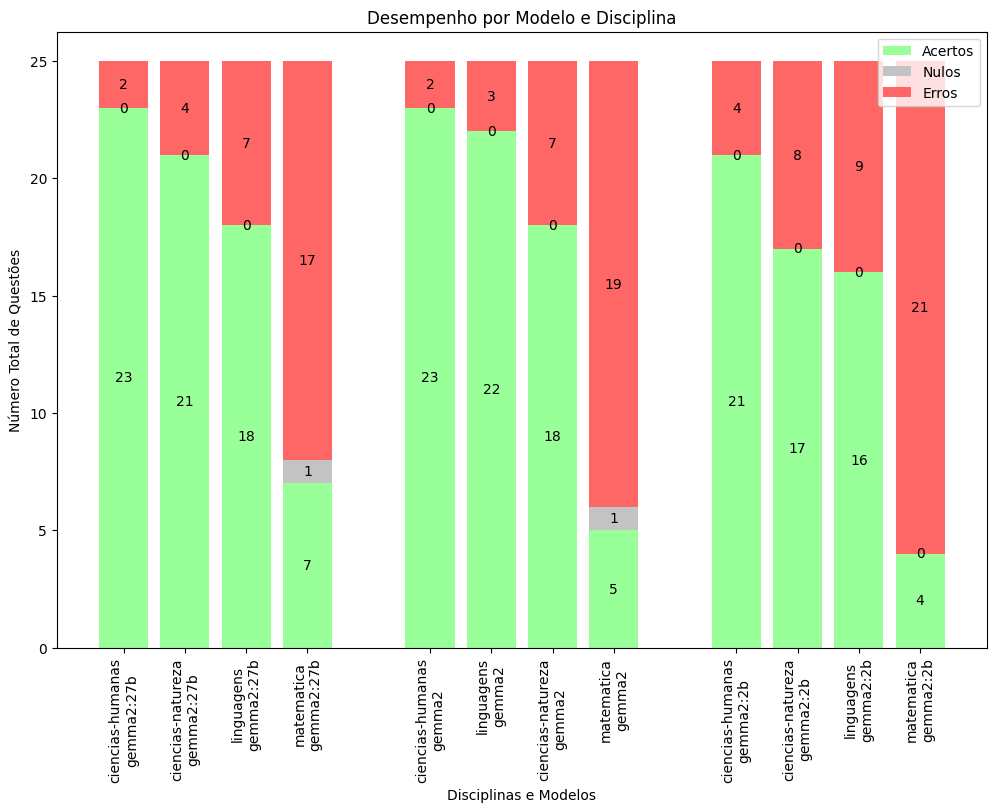

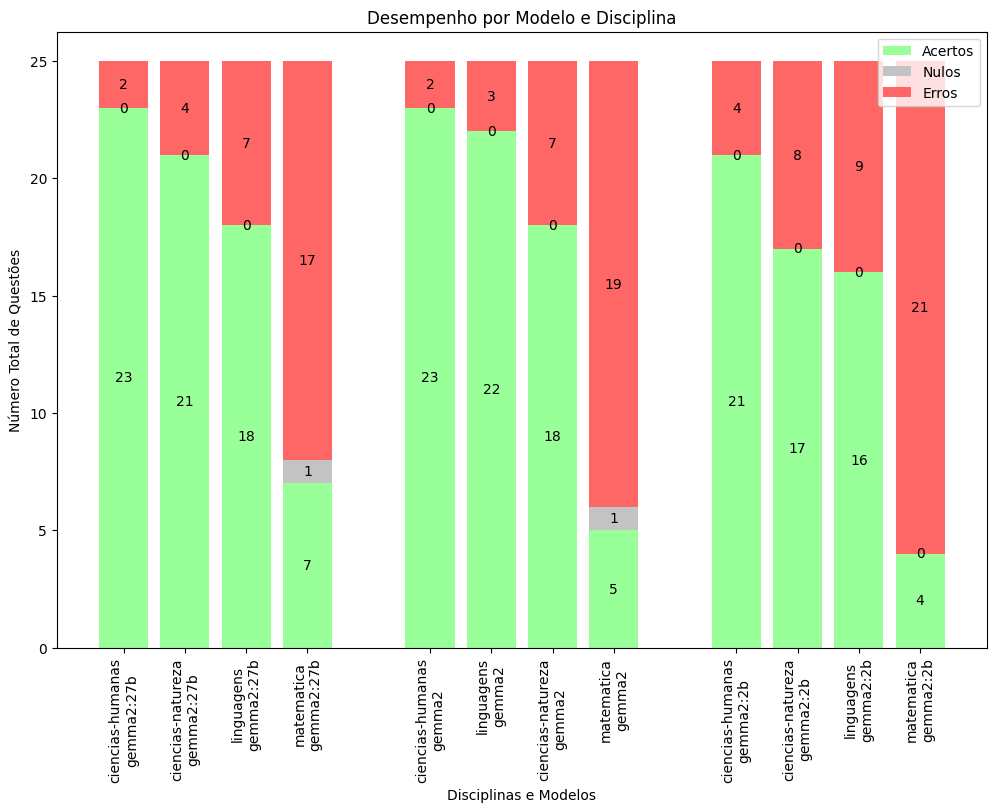

In [33]:
plots.discipline_performance(gemma_models, example_text_questions, True, False)

#### 2.1.3 - Análise Comparativa dos Modelos  

Com base nos dados apresentados, observamos que há uma **diferença significativa** de desempenho entre os modelos mais robustos e os modelos mais leves. No entanto, ao compararmos um modelo **intermediário** com um modelo mais robusto, essa diferença torna-se **pouco expressiva**, sugerindo que modelos intermediários podem oferecer um desempenho equivalente na maioria dos cenários. No caso do **Gemma2**, identificamos uma variação entre os acertos por disciplina, com **diferenças mais notáveis entre os modelos**, o que indica que alguns domínios podem ser mais sensíveis à quantidade de parâmetros do modelo.  

##### **Impacto Temporal e Considerações Computacionais**  

Em termos de **tempo de inferência**, o modelo mais robusto apresentou **tempos de execução mais elevados** em todos os testes. Esse comportamento pode ser explicado por dois fatores principais:  

1. **Consumo de memória** – Modelos maiores tendem a exigir mais memória, sendo preferencialmente executados em **memória de vídeo (VRAM)** para maior eficiência. No entanto, se o modelo ultrapassar a capacidade da GPU disponível, ele será carregado na **memória RAM**, que possui uma **frequência menor**, impactando diretamente no tempo de inferência.  
2. **Número de combinações avaliadas** – Modelos com maior número de parâmetros possuem **mais possibilidades de ajuste para cada predição**, o que pode levar a um aumento no tempo de resposta.  

Esses fatores reforçam a necessidade de um equilíbrio entre **qualidade da resposta e viabilidade computacional**, especialmente em aplicações que demandam tempo de resposta reduzido e menor consumo de recursos.  

In [34]:
from lib.utils import get_predict_data
import pandas as pd

predict_data = get_predict_data(["gemma2", "gemma2:27b", "qwen2.5:14b", "qwen2.5:7b",], example_text_questions)

questoes = set(int(p["question"]) for p in predict_data.values())

predicts_list = []

for quest in questoes:
    predicts_list.append({
        "question-model" : f"{quest}-gemma",
        "medium" : 1 if predict_data[f"{quest}-gemma2"]["correct"] else 0,
        "large" : 1 if predict_data[f"{quest}-gemma2:27b"]["correct"] else 0
    })
    
    predicts_list.append({
        "question-model" : f"{quest}-qwen2.5",
        "medium" : 1 if predict_data[f"{quest}-qwen2.5:7b"]["correct"] else 0,
        "large" : 1 if predict_data[f"{quest}-qwen2.5:14b"]["correct"] else 0
    })

predicts_df = pd.DataFrame(predicts_list)

In [35]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(predicts_df["medium"], predicts_df["large"])

print(f"Estatística t: {t_stat:.4f}, Valor-p: {p_value:.4f}")

# Nível de significância
alpha = 0.05

if p_value > alpha:
    print("Aceitamos H₀: Os modelos são estatisticamente equivalentes em acurácia.")
else:
    print("Rejeitamos H₀: Existe uma diferença significativa no desempenho dos modelos.")

Estatística t: -0.1597, Valor-p: 0.8732
Aceitamos H₀: Os modelos são estatisticamente equivalentes em acurácia.


In [36]:
from statsmodels.stats.weightstats import ttost_paired

# Definir intervalo de equivalência
eq_low, eq_high = -0.02, 0.02  

# Aplicação do TOST para testar equivalência
tost_p_value = ttost_paired(predicts_df["medium"], predicts_df["large"], low=eq_low, upp=eq_high)[0]

print(f"Valor-p do TOST: {tost_p_value:.4f}")

if tost_p_value < alpha:
    print("Rejeitamos H₀: Os modelos são estatisticamente equivalentes.")
else:
    print("Aceitamos H₀: Não há evidências suficientes para afirmar equivalência.")


Valor-p do TOST: 0.3162
Aceitamos H₀: Não há evidências suficientes para afirmar equivalência.


##### **Formulação e Teste da Hipótese Nula**  

Para avaliar a equivalência entre modelos intermediários e robustos, formulamos a seguinte hipótese estatística:  

**Hipótese Nula ($H_0$):**  
$$
\mu_{\text{intermediário}} = \mu_{\text{robusto}}
$$
Ou seja, a **média de acertos do modelo intermediário** ($\mu_{\text{intermediário}}$) é estatisticamente equivalente à **média de acertos do modelo robusto** ($\mu_{\text{robusto}}$), indicando que ambos possuem desempenhos similares.  

**Hipótese Alternativa ($H_1$):**  
$$
\mu_{\text{intermediário}} \neq \mu_{\text{robusto}}
$$
Essa hipótese alternativa indicaria que existe uma **diferença estatisticamente significativa** entre os modelos, sugerindo que um deles apresenta um desempenho superior ao outro.  

##### **Resultados dos Testes Estatísticos**  

Para validar essa hipótese, aplicamos **dois testes estatísticos**:  

1. **Teste t de Student**, que avalia se há uma diferença significativa entre os modelos.  
2. **Teste de Equivalência (TOST)**, que verifica se a diferença de desempenho entre os modelos está dentro de um intervalo previamente definido como aceitável.  

Os resultados obtidos foram os seguintes:  

- **Teste t de Student ($\alpha = 0.05$)**:  
  - Estatística t: **-0.1597**  
  - Valor-p: **0.8732**  
  - **Conclusão**: Como $p > 0.05$, **aceitamos $H_0$**, indicando que **não há diferença estatisticamente significativa** entre os modelos intermediário e robusto.  

- **Teste de Equivalência (TOST) com intervalo de $[-0.02, 0.02]$**:  
  - Valor-p: **0.3162**  
  - **Conclusão**: Como $p > 0.05$, **não há evidências suficientes para afirmar equivalência** dentro do intervalo estabelecido.  

##### **Interpretação dos Resultados**  

Os resultados obtidos demonstram que **os modelos intermediário e robusto possuem desempenhos estatisticamente similares**, pois o teste t de Student **não encontrou diferença significativa** entre eles. No entanto, o teste de equivalência **não conseguiu confirmar que os modelos estão dentro do intervalo de tolerância de ±2%**, o que significa que **a equivalência estatística não pode ser garantida dentro desse critério específico**.  

Dessa forma, podemos concluir que **o aumento no número de parâmetros não implica necessariamente em uma melhoria significativa no desempenho**, mas também que **não podemos afirmar que um modelo intermediário é equivalente a um robusto dentro da margem de erro estipulada**.  

Na prática, a escolha entre um modelo intermediário ou robusto deve considerar não apenas a acurácia estatística, mas também **fatores como tempo de inferência, consumo de memória e viabilidade computacional**, uma vez que modelos intermediários podem oferecer benefícios significativos em eficiência sem comprometer substancialmente a qualidade das respostas.  


### 2.2 - Avaliação de Modelos de Reasoning  

Nesta seção, analisamos o desempenho dos **modelos de Reasoning**, que, devido à sua estrutura avançada de processamento e raciocínio, são esperados apresentar **melhor desempenho** em tarefas que exigem lógica e cálculos mais complexos. Para esse experimento, utilizamos os seguintes modelos: **Deepscaler**, **Deepseek-r1**, **Mistral-nemo**, **Openthinker** e **Smallthinker** .

##### **Tempo de Execução e Uso de Tokens**  

Observamos uma **diferença significativa no tempo de inferência** desses modelos em comparação com os testados anteriormente. Alguns deles apresentaram a tag `<think>`, que representa uma etapa explícita de raciocínio antes da resposta final. Essa estrutura resultou em **respostas mais longas**, com um maior número de **tokens**, o que impactou diretamente no tempo de processamento.  

Um caso extremo foi o **Openthinker**, que levou **mais de 1h24min** para processar **100 questões**, resultando em uma média de aproximadamente **50 segundos por questão**. Em contraste, o modelo **Gemma2:27b**, que anteriormente apresentou o maior tempo de execução entre os modelos testados, levou **cerca de 12 minutos** para concluir o mesmo teste.  

Vale ressaltar que, diferentemente do **Gemma2:27b**, cujo tempo elevado se deve ao alto consumo de **VRAM**, os modelos de reasoning são **mais leves em tamanho**, sugerindo que o tempo prolongado pode estar mais relacionado ao **processamento adicional de raciocínio**. Essa tendência foi observada em **todos os modelos**, exceto pelo **Mistral-nemo**, que conseguiu um tempo de inferência reduzido. 

Um outro fator importante foi o excesso de **timeout**, com os demais modelos não tivemos problemas, mas o **smallthinker** apresentou uma incostância muito grande, travando a execução, tendo que ser implementado um timeout para impedir que ele interrompesse os teste.

##### **Acurácia e Desempenho por Disciplina**  

Em relação às **métricas de acurácia**, os resultados foram variados:  

- Apenas o **Deepscaler** apresentou um desempenho **inferior** aos modelos convencionais testados anteriormente.  
- Os demais modelos tiveram valores **próximos** aos obtidos pelos modelos **não-reasoning**.  
- Em **matemática**, esperava-se que os modelos reasoning apresentassem **um desempenho superior**, devido à sua **capacidade aprimorada de cálculos**. No entanto, apenas o **Deepseek-r1** obteve **mais de 50% de acertos** nessa disciplina, enquanto nas demais áreas seu desempenho foi inferior, especialmente em **ciências da natureza**.  

##### **Respostas Nulas e Impacto no Não-Determinismo**  

Um fenômeno observado nesses modelos foi a **alta taxa de respostas nulas**, especialmente em **matemática**. Respostas nulas ocorreram quando o modelo **não seguiu corretamente a instrução de resposta**, por exemplo:  

- Em vez de fornecer a **alternativa correta**, o modelo apresentava o **resultado do cálculo**.  
- Algumas respostas continham explicações extensas, mas sem indicar diretamente a alternativa correta.  

Esse comportamento indica que a **camada adicional de raciocínio pode impactar o determinismo do modelo**, tornando suas respostas menos previsíveis e mais propensas a **desvios das instruções originais**.  

##### **Considerações Finais**  

Os modelos de reasoning apresentaram **vantagens e desvantagens** claras. Enquanto alguns conseguiram **bons desempenhos em acurácia**, houve um **custo expressivo em tempo de inferência**. Além disso, a **tendência a respostas mais elaboradas e menos diretas** pode ser um desafio em aplicações que exigem **alta confiabilidade e aderência estrita às instruções**.  


,Model,Size,Finish,OK,Null,Tout,Err,Acc,Prec,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,deepseek-r1,7.0,100 (20.0%),65,6,0,29,0.650,0.691489,32:32,32:32,0.00,19.53,01:52,4.96
1,mistral-nemo,7.1,100 (20.0%),65,2,0,33,0.650,0.663265,04:34,04:34,0.00,2.75,14.25,0.22
2,openthinker,4.7,100 (20.0%),60,15,0,25,0.600,0.705882,01:24:44,01:24:44,0.00,50.85,09:02,9.70
3,smallthinker,3.6,100 (20.0%),53,0,11,36,0.530,0.595506,18:20,40:20,0.00,11.00,27.32,4.87
4,deepscaler,3.6,100 (20.0%),29,11,0,60,0.290,0.325843,43:28,43:28,0.00,26.08,05:24,3.82
5,TOTAL,26.0,500 (20.0%),272,34,11,183,0.544,0.597802,03:03:40,03:25:40,0.00,22.04,09:02,0.22


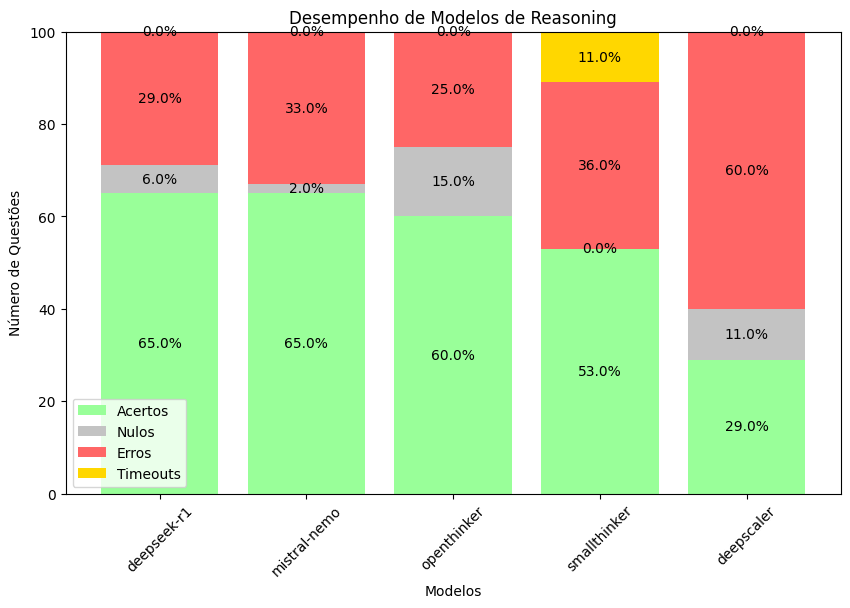

In [37]:
reason_models = ["deepscaler", "deepseek-r1", "mistral-nemo", "openthinker", "smallthinker"]

test_result = test_models(
    primary_models=reason_models,
    questions=example_text_questions,
    timeout = 100
)

reason_table = lib.utils.test_table(
    questions=example_text_questions,
    models=reason_models
    
)

clear_output(wait=True)
display(lib.utils.format_test_table(reason_table))
plots.model_performance(reason_table, "Desempenho de Modelos de Reasoning")
None

Analisando a acurácia do modelos, notamos que o desempenho se mostrou bastante similar aos modelos anteriores, demonstrando que talvez uma algoritmo de reasoning não tenha sido tão eficiente comparado com outros modelos. Outro ponto interessante é que o openthinker teve um desempenho próximo dos outros melhores modelos.

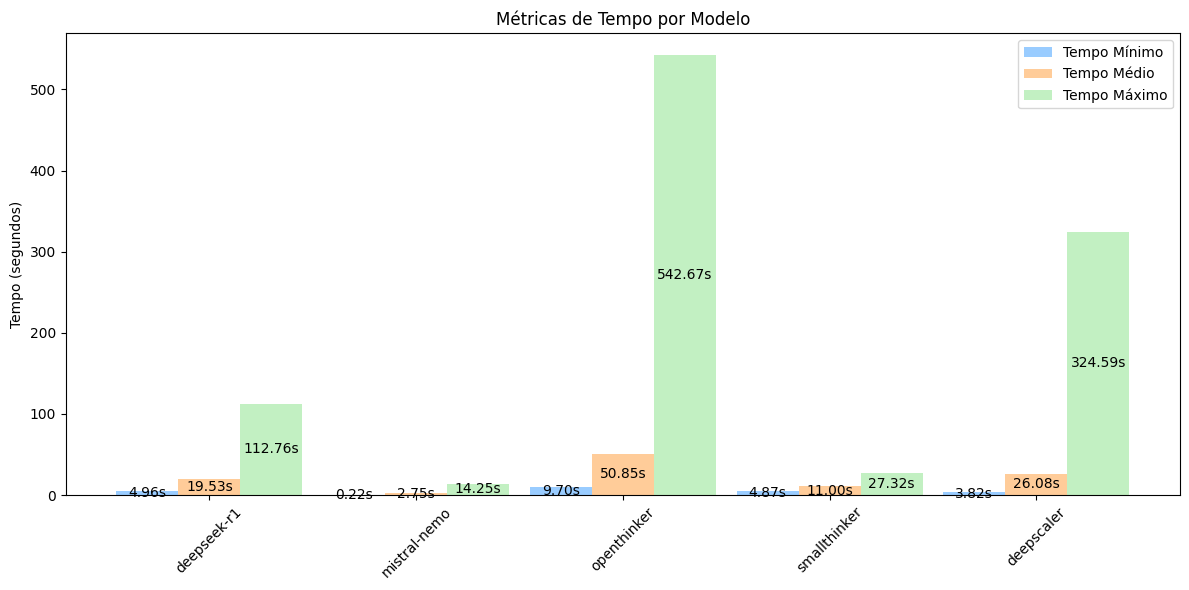

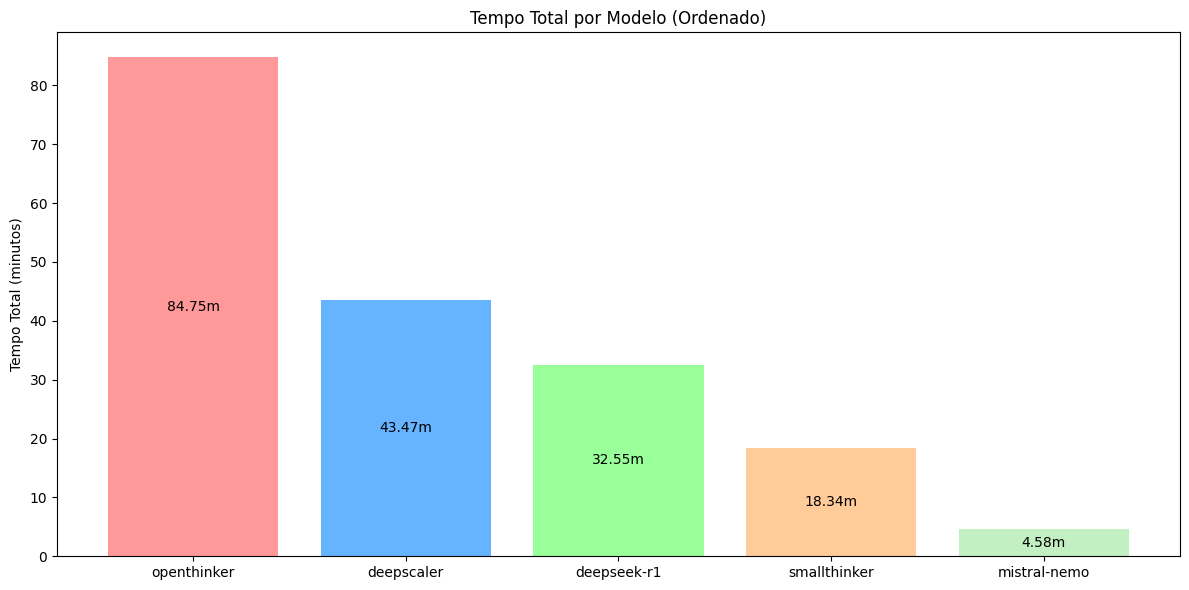

In [38]:
plots.time_metrics(reason_table)
plots.time_metrics_total(reason_table)
None

Porém ao analisarmos o tempo dos modelos, o **ministral-nemo** possuiu um tempo bastante similar aos dois modelos anteriores, porém, nos demais, principamente o openthinker apresentaram tempos muito superiores, chegando a quase 18.5x do modelo com menor tempo, ou seja, tivemos uma acurácia nos melhores casos muito próxima dos modelos anteriores que possuem um tempo significamente menor. É importante, pontuar que os modelos com exceção ao ministral-nemo, tiveram um tempo máximo muito alto, chegado a mais de 500 segundos em um exemplo. 

### 2.3 - Avaliação de Modelos Focados em Matemática  

Nesta seção, analisamos o desempenho de modelos especializados em matemática, avaliando se sua otimização para essa área impacta significativamente a acurácia em diferentes disciplinas. Os modelos testados foram o **Mathstral**, uma variação do **Mistral 7B** com aprimoramento em ciências da natureza e matemática, e o **Qwen2-Math**, uma versão especializada do **Qwen2**, testada nas configurações de **1.5B** e **7B** parâmetros.  

Ao comparar esses modelos com os testados anteriormente, observamos que sua acurácia geral foi inferior, sugerindo que, apesar do foco em matemática, seu desempenho em outras disciplinas foi prejudicado. Em especial, notamos um desempenho bastante reduzido em linguagens, onde o maior número de acertos registrado foi de apenas **11**, um resultado significativamente inferior ao dos modelos intermediários analisados previamente.  

Além da acurácia, analisamos também o tempo de inferência. Os resultados demonstram que as duas versões do **Qwen2-Math** apresentaram uma diferença mínima em termos de acurácia, no entanto, a versão **1.5B teve um tempo médio de inferência muito superior** ao da versão **7B**. Já o **Mathstral**, que possui um tamanho similar ao **Qwen2-Math:7B**, levou **mais do que o dobro do tempo** para concluir o teste, o que indica que diferenças arquiteturais podem ter impactado significativamente sua eficiência computacional.  

Embora a expectativa fosse de que esses modelos apresentassem um desempenho significativamente superior em matemática, os resultados mostraram que essa melhora não foi expressiva. O modelo que obteve o melhor desempenho na disciplina foi o **Mathstral7b**, porém, de forma surpreendente, o **Qwen2-Math:1.5B**, que, mesmo possuindo **uma quantidade muito inferior de parâmetros**, superou o desempenho de sua variação de parâmetros maior, e ainda conseguiu ser mais rápido como cidato anteriormente.  

Diante desses resultados, é possível concluir que modelos especializados em matemática **não necessariamente garantem um desempenho superior na disciplina** e, em contrapartida, apresentam **quedas expressivas em outras áreas**, tornando-os menos versáteis. Além disso, a relação entre **tamanho do modelo, tempo de inferência e acurácia** nem sempre segue um padrão linear, como evidenciado pelo desempenho do **Qwen2-Math:1.5B**, que, apesar de menor, apresentou os melhores resultados em sua categoria.  


,Model,Size,Finish,OK,Null,Tout,Err,Acc,Prec,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,mathstral,4.1,100 (33.3%),56,9,0,35,0.560000,0.615385,10:38,10:38,0.00,6.39,23.44,0.25
1,qwen2-math:7b,4.4,100 (33.3%),37,0,0,63,0.370000,0.370000,40.43,40.43,0.00,0.40,4.43,0.16
2,qwen2-math:1.5b,0.9,100 (33.3%),26,3,0,71,0.260000,0.268041,04:35,04:35,0.00,2.76,6.40,0.21
3,TOTAL,9.4,300 (33.3%),119,12,0,169,0.396667,0.413194,15:54,15:54,0.00,3.18,23.44,0.16


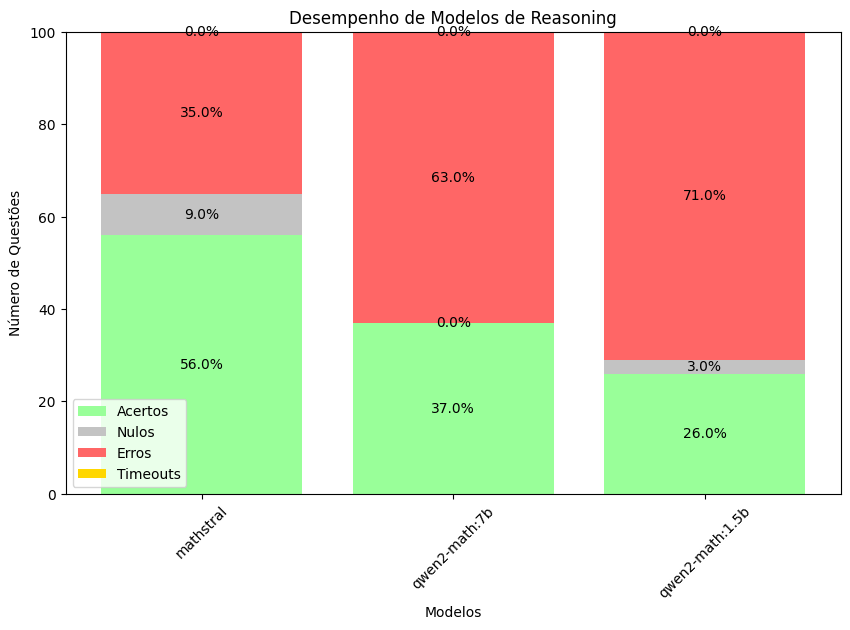

In [39]:
math_models = ["qwen2-math:1.5b", "qwen2-math:7b", "mathstral"]

math_table = lib.utils.test_table(
    questions=example_text_questions,
    models=math_models
)

display(lib.utils.format_test_table(math_table))
plots.model_performance(math_table, "Desempenho de Modelos de Reasoning")
None

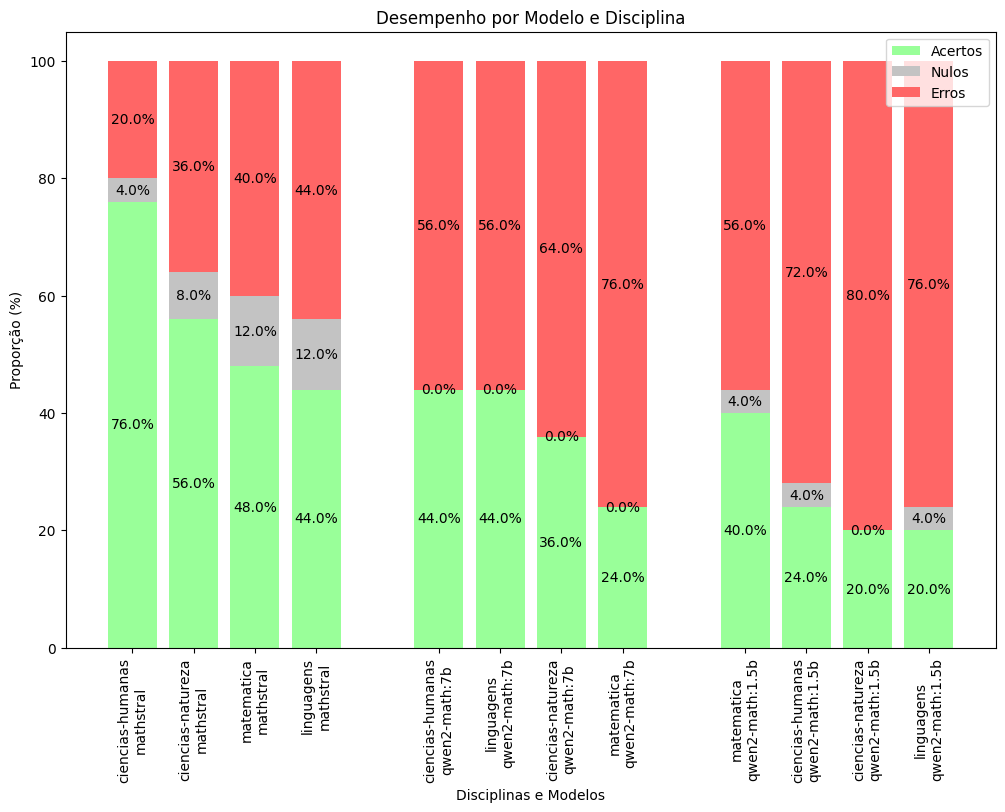

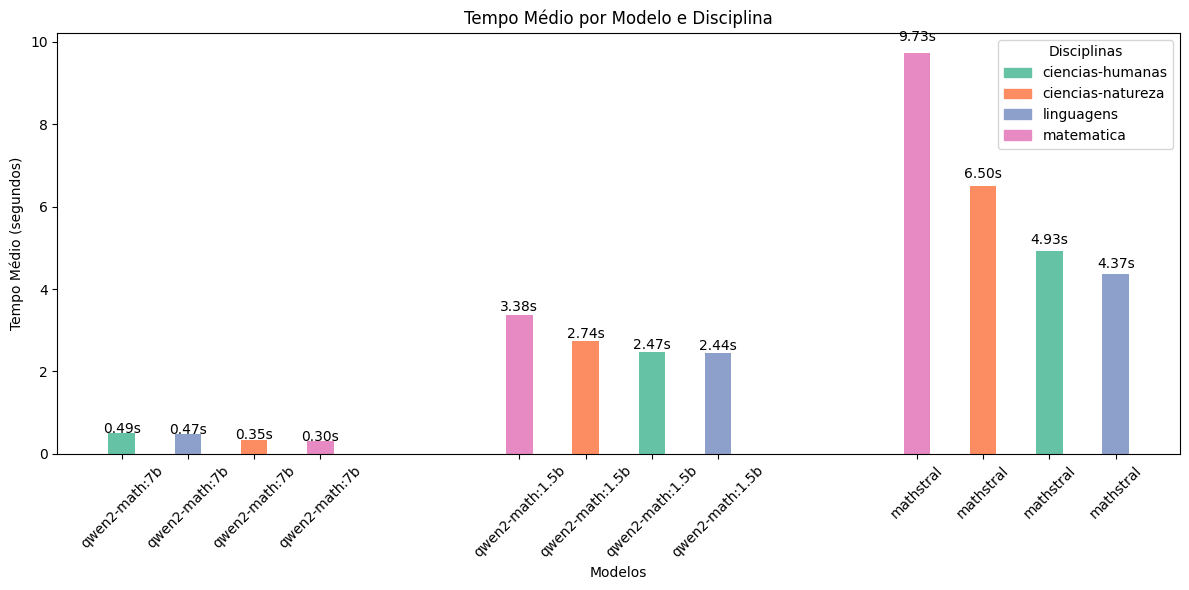

In [40]:
plots.discipline_performance(math_models, example_text_questions,True, True)
plots.discipline_time_performance(math_models, example_text_questions, True)
None

### 2.4 - Avaliação dos Demais Modelos  

Por fim, realizamos testes com os modelos restantes focados em **processamento de texto**, além de um modelo com **suporte à visão**, com o objetivo de avaliar o desempenho de um modelo multimodal. Esses resultados servirão como base para comparações futuras, especialmente quando analisarmos o desempenho dos modelos em questões que envolvem imagens.  

Os modelos que obtiveram os melhores resultados em **acurácia geral** foram o **Phi-4** e o **Mistral-Small**, ambos apresentando **mais de 70% de precisão**. No entanto, observamos que o **Mistral-Small teve um tempo de execução significativamente superior aos demais**, levando **aproximadamente 44 minutos** para concluir o teste. Além disso, os modelos desenvolvidos pela **Microsoft** também apresentaram **tempos de inferência mais elevados**, embora **não tão acentuados quanto o Mistral-Small**.  

Um fenômeno incomum foi observado no modelo **Phi-3.5**. Durante as primeiras questões, o modelo demonstrou **bom desempenho**, respondendo de maneira coerente. No entanto, conforme o teste progrediu, o modelo começou a apresentar **alucinações**, gerando respostas totalmente distintas das solicitadas. Esse comportamento impactou diretamente o número de **respostas nulas**, resultando em uma taxa alarmante de **83% de questões inválidas**.  

Ao analisarmos o gráfico de **correlação entre tempo médio e acurácia**, constatamos que o modelo que obteve **o melhor equilíbrio entre desempenho e tempo de execução** foi o **Phi-4**, pois alcançou **excelentes resultados sem comprometer significativamente o tempo de processamento**. Por outro lado, o desempenho do **Mistral-Small** pode ter sido influenciado pela **limitação de hardware**. Como o modelo possui um tamanho de **14GB**, mas foi executado em uma **placa de vídeo com 12GB de VRAM**, parte do processamento foi deslocado para a **memória RAM**, resultando em um maior tempo de carregamento e execução. Esse fator pode ter impactado diretamente sua velocidade e eficiência durante o teste.  

Ao analisarmos o desempenho por disciplina, os modelos **Phi-4** e **Mistral-Small** surpreenderam ao apresentar **um desempenho superior em matemática** quando comparados aos modelos projetados especificamente para essa área. O **Phi-4**, em particular, atingiu **92% de precisão** em matemática, mantendo **um desempenho consistente em todas as demais disciplinas**, o que indica sua **elevada capacidade geral** em relação aos outros modelos testados.  

Outro dado relevante foi a comparação entre o modelo **Mistral** e sua variação especializada em matemática (**Mathstral**). O **Mathstral**, que passou por um processo de fine-tuning voltado para cálculos e raciocínio lógico, demonstrou um **desempenho significativamente superior** ao modelo base. Enquanto o **Mathstral** obteve **12 acertos em matemática**, o **Mistral padrão acertou apenas 3**, evidenciando uma melhora de **400%**. Esse resultado confirma que o fine-tuning foi **bem-sucedido**, tornando o modelo especializado **mais eficiente na resolução de problemas matemáticos**. Em outras disciplinas, no entanto, os dois modelos apresentaram desempenhos variados, com o modelo base tendo um acero a mais em ciências da natureza e 5 a mais em linguagens, enquando o modelo com fine-tunnig mostrou um desempenho superior, além do já mencionado, em ciências humanas. 

Um dos modelos que se destacou em termos de **desempenho global** foi o **Phi-4**. Seu desempenho nas diferentes disciplinas foi **consistente e expressivo**. O modelo obteve **92% de acertos em ciências humanas**, **76% em linguagem**, **84% em ciências da natureza** e **um impressionante 92% em matemática**, consolidando-se como um dos melhores modelos em termos de **acurácia geral**. Esse resultado indica que, mesmo com seu comportamento instável em longas execuções, o **Phi-3.5 demonstrou um nível de compreensão bastante elevado**, sendo capaz de lidar com questões de diferentes áreas com alto índice de acertos.  

De maneira geral, os modelos analisados nesta seção demonstraram **desempenhos distintos dependendo do critério avaliado**. Enquanto **Phi-4** se destacou pelo equilíbrio entre **tempo de inferência e acurácia**, **Mistral-Small** apresentou resultados robustos, porém com um custo computacional elevado. O modelo **Phi-3.5**, por sua vez, revelou um desempenho impressionante em todas as disciplinas, especialmente em matemática, mas sofreu com um número elevado de respostas inválidas ao longo do teste. Essas diferenças evidenciam que a escolha do modelo ideal deve levar em consideração **não apenas a acurácia bruta, mas também o tempo de inferência, estabilidade das respostas e adequação às tarefas específicas**.  


,Model,Size,Finish,OK,Null,Tout,Err,Acc,Prec,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,phi4,9.1,100 (16.7%),86,0,0,14,0.860000,0.860000,12:34,12:34,0.00,7.55,32.99,1.70
1,mistral-small,14.0,100 (16.7%),78,4,0,18,0.780000,0.812500,44:21,44:21,0.00,26.61,04:11,1.02
2,mistral,4.1,100 (16.7%),51,3,0,46,0.510000,0.525773,01:57,01:57,0.00,1.18,20.85,0.22
3,llava,4.7,100 (16.7%),40,3,0,57,0.400000,0.412371,01:16,01:16,0.00,0.76,10.90,0.18
4,llama3.2,2.0,100 (16.7%),25,2,0,73,0.250000,0.255102,30.14,30.14,0.00,0.30,7.85,0.09
5,phi3.5,2.2,100 (16.7%),16,83,0,1,0.160000,0.941176,13:23,13:23,0.00,8.04,02:07,0.29
6,TOTAL,36.1,600 (16.7%),296,95,0,209,0.493333,0.586139,01:14:03,01:14:03,0.00,7.41,04:11,0.09


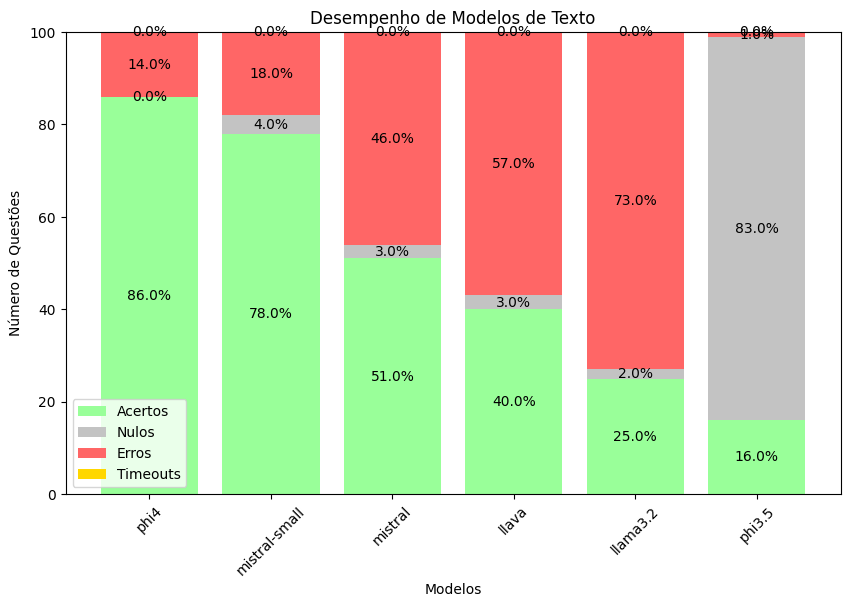

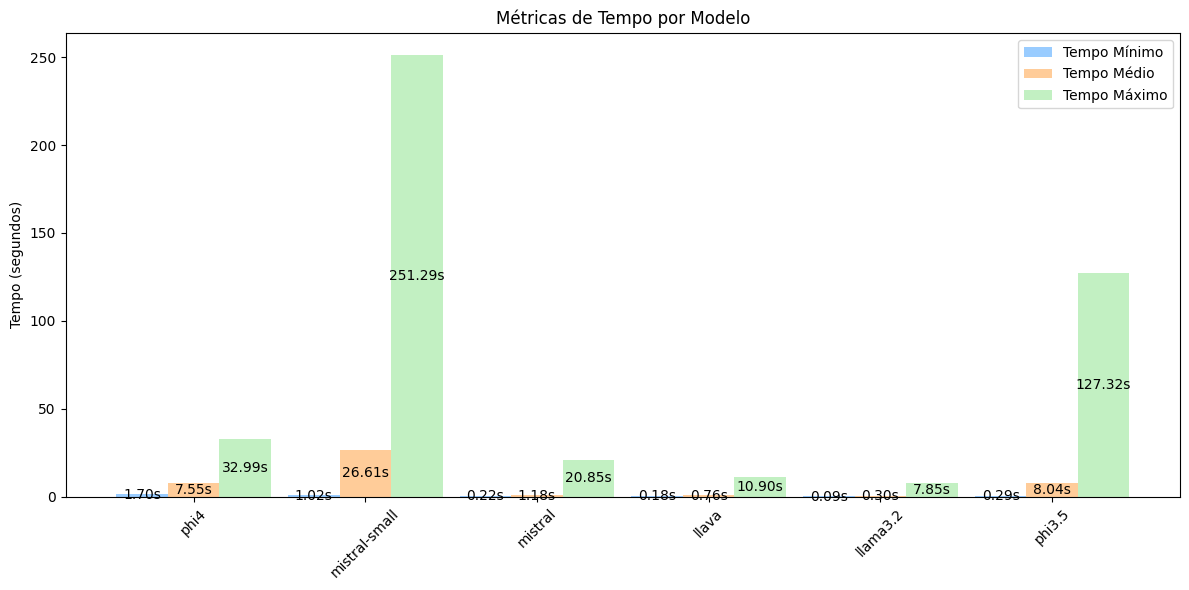

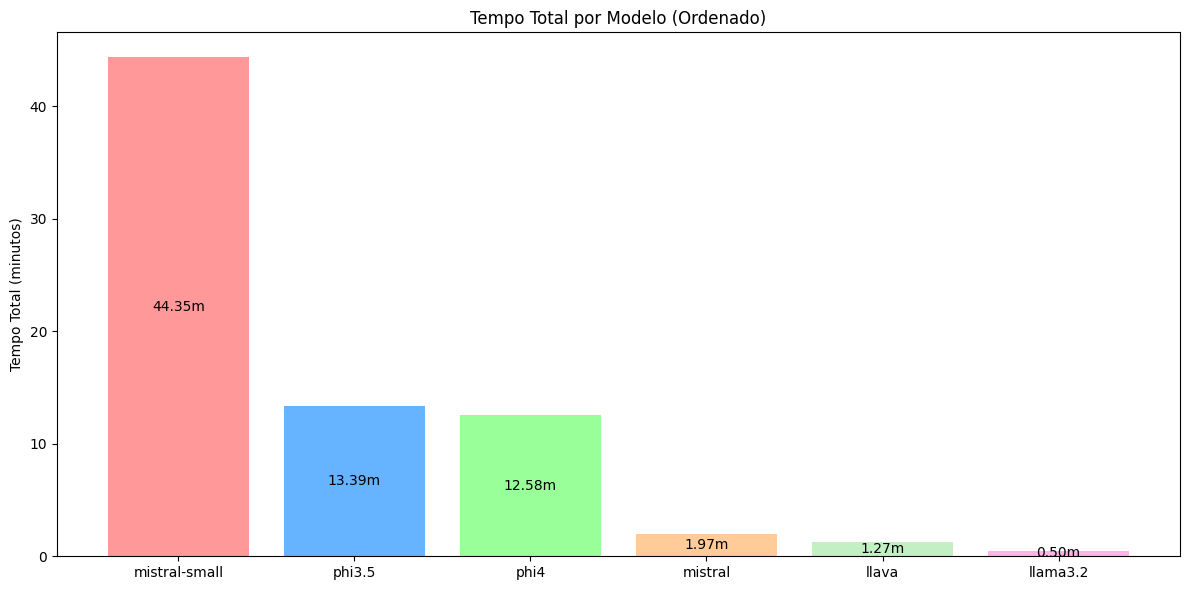

In [41]:
text_models = ["phi4", "phi3.5", "llava", "llama3.2", "mistral", "mistral-small"]

text_table = lib.utils.test_table(
    questions=example_text_questions,
    models=text_models
)

display(lib.utils.format_test_table(text_table))
plots.model_performance(text_table, "Desempenho de Modelos de Texto")
plots.time_metrics(text_table)
plots.time_metrics_total(text_table)
None

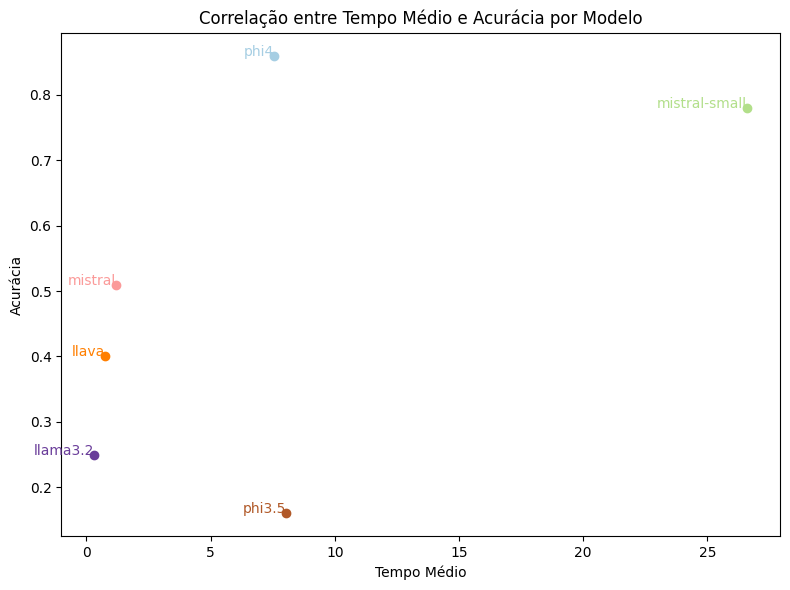

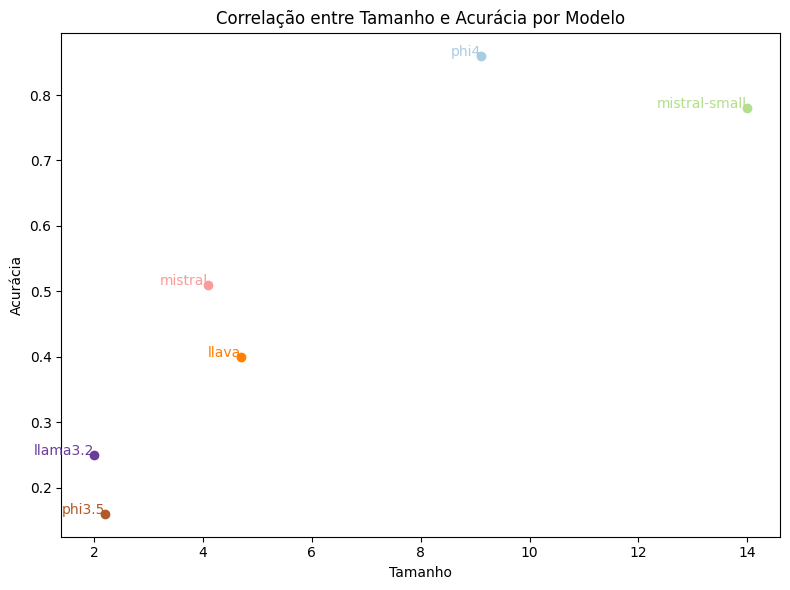

In [42]:
plots.correlation(text_table, "Tavg", "Acc")
plots.correlation(text_table, "Size", "Acc")
None

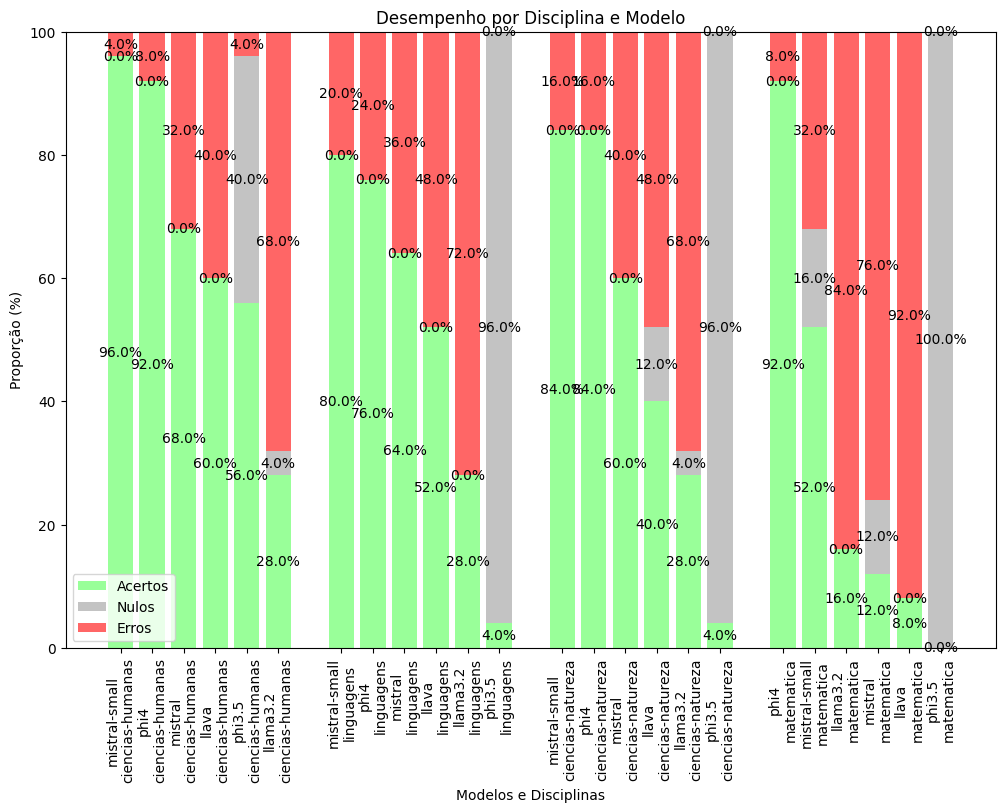

In [43]:
plots.discipline_performance(text_models, example_text_questions, normalize=True)
None

### 2.5 - Análise de Desempenho por Disciplina  

Com a finalização dos testes para cada categoria de modelo, passamos agora a uma análise mais detalhada do **desempenho por disciplina**. O objetivo é compreender como os diferentes modelos se comportam em cada área do conhecimento, identificando padrões, pontos fortes e eventuais limitações em suas respostas.  


In [44]:
all_text_models = qwen_models + math_models + reason_models + text_models + gemma_models
text_table = lib.utils.tabela_geral(example_text_questions, all_text_models)
table_disciplinas = lib.utils.analisar_tabela(text_table, 'discipline')
table_disciplinas

,discipline,Total,OK,Null,Err,Tout,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,ciencias-humanas,500.0,337.0,13.0,150.0,0.0,2486.978633,2486.978633,0.0,4.973957,127.324694,0.082505
1,ciencias-natureza,500.0,284.0,39.0,177.0,0.0,3614.083519,3614.083519,0.0,7.228167,173.496423,0.080599
2,linguagens,500.0,279.0,35.0,182.0,4.0,2556.072177,2556.072177,0.0,5.112144,77.246623,0.000000
3,matematica,500.0,152.0,69.0,272.0,7.0,9064.134524,9064.134524,0.0,18.128269,542.666862,0.000000


Observando o desemprenho individual de cada disciplina em todos os modelosde texto, nota-se que Matemática é a principal dificuldade dos modelos, uma vez que o seu tempo de execução é superior aos demais somados, além de que a Acurácia de Todos os modelos chegou a 31.33%, enquanto os outros modelos conseguiram uma acurácia entre 54.44% a 65.11%

#### 2.5.1 Matemática

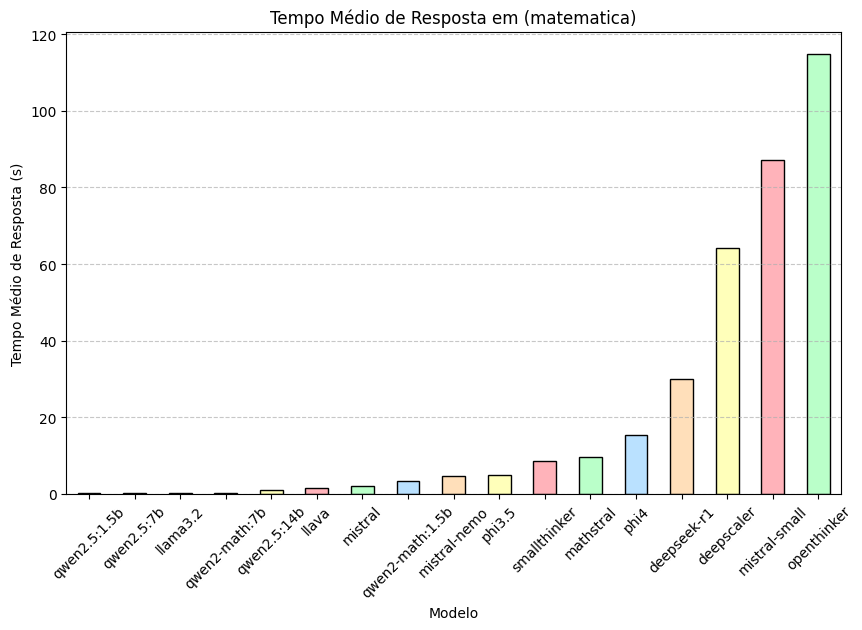

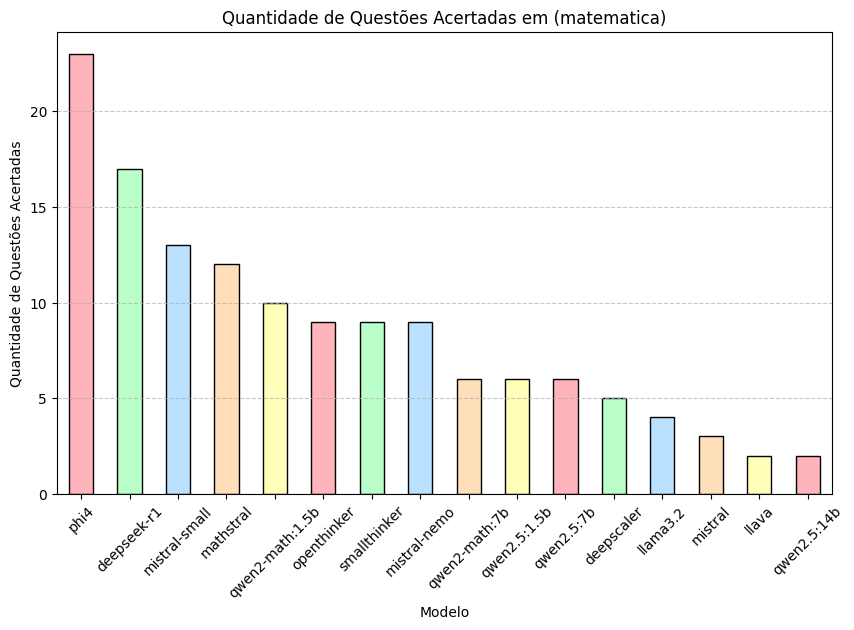

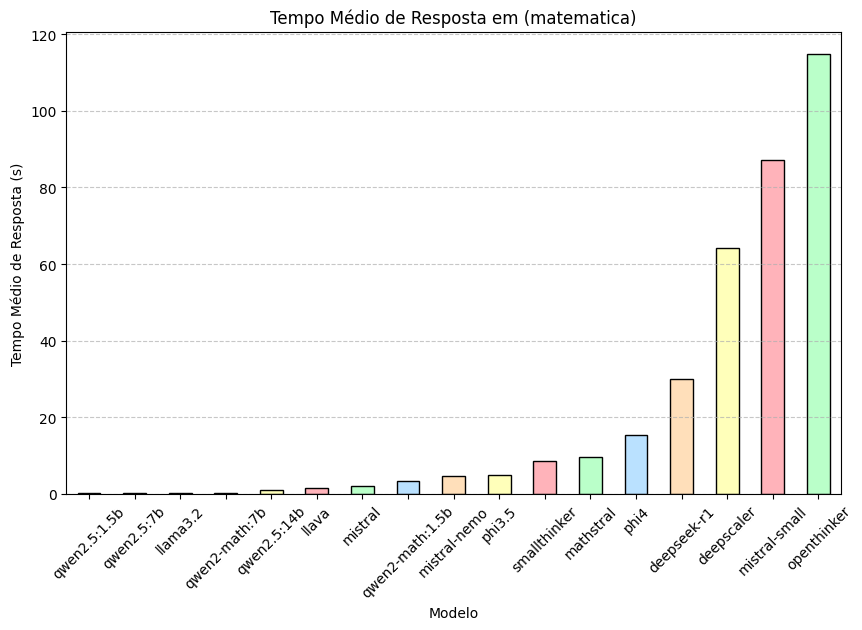

In [ ]:
plots.discipline_models(text_table, 'matematica', 'acc')
plots.discipline_models(text_table, 'matematica', 'time')
None

Em relação ao tempo de execução, as questões de **matemática** apresentaram um tempo médio significativamente superior ao das demais disciplinas, atingindo em média 20,48 segundos por questão, enquanto nas outras áreas do conhecimento nenhuma ultrapassou 8 segundos em média. Essa diferença evidencia que os modelos demandam um tempo consideravelmente maior para processar e responder questões matemáticas, possivelmente devido à necessidade de operações aritméticas ou dificuldades na interpretação das expressões.

Além disso, o tempo máximo registrado para uma única questão de matemática foi de **542 segundos**, um valor muito superior ao tempo máximo observado em outras disciplinas, cujo segundo maior tempo registrado foi de **173,49 segundos**. Essa discrepância sugere que certas questões matemáticas exigem **muito mais processamento**, podendo ativar mecanismos internos dos modelos, como **passos adicionais de raciocínio, tentativa de cálculos detalhados ou maior esforço na busca por padrões matemáticos**. Esse comportamento não foi observado com a mesma intensidade em disciplinas como **linguagens e ciências humanas**, onde as respostas parecem ser geradas com maior rapidez e consistência.  

Esses resultados reforçam a hipótese de que questões matemáticas **impõem uma carga computacional maior** aos modelos, tornando sua resolução **mais lenta e sujeita a variações** quando comparada a outras áreas do conhecimento.  

#### 2.5.2 - Desempenho em Ciências Humanas  

A disciplina de **Ciências Humanas** apresentou um desempenho **superior à maioria das demais áreas**, com uma **acurácia média de 67%** entre os modelos testados. Além disso, o **tempo médio de inferência** foi relativamente **baixo**, sendo **muito próximo ao da disciplina de Linguagens**, com uma diferença de apenas **0,0139 segundos**.  

O bom desempenho nessa disciplina pode estar relacionado ao **tipo de questão abordada**, que, em muitos casos, exige uma resposta mais **direta e factual**, reduzindo a necessidade de **interpretação subjetiva**. Isso pode ter facilitado a geração de respostas corretas pelos modelos, diferentemente do que ocorre em disciplinas que exigem um maior nível de inferência contextual.  

Embora a média geral tenha sido positiva, alguns modelos se destacaram de forma significativa. **Oito modelos** conseguiram acertar **20 ou mais questões**, um resultado expressivo quando comparado a outras disciplinas. Esse dado reforça que **os modelos de linguagem estão relativamente bem ajustados para esse tipo de conteúdo**, conseguindo lidar com conceitos históricos, geográficos e sociais de maneira eficaz.  

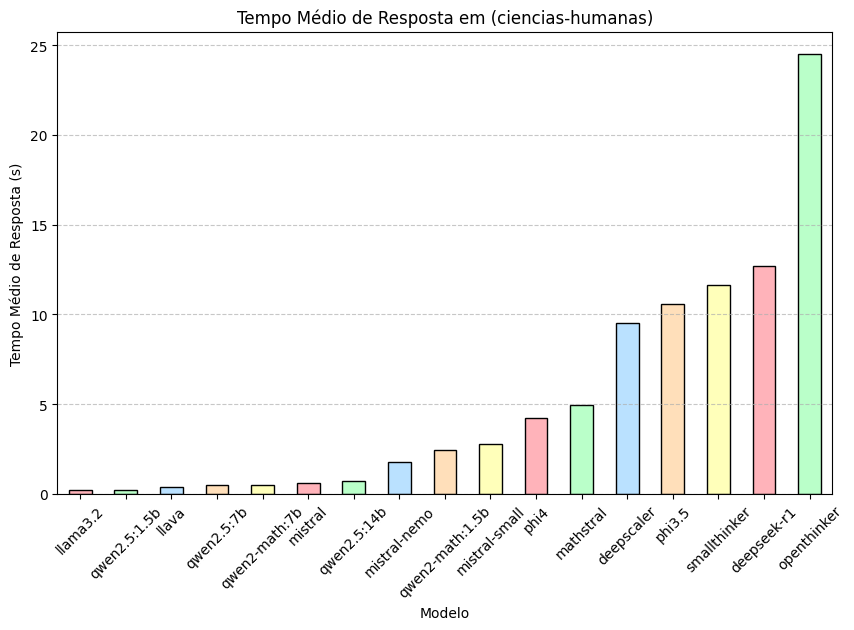

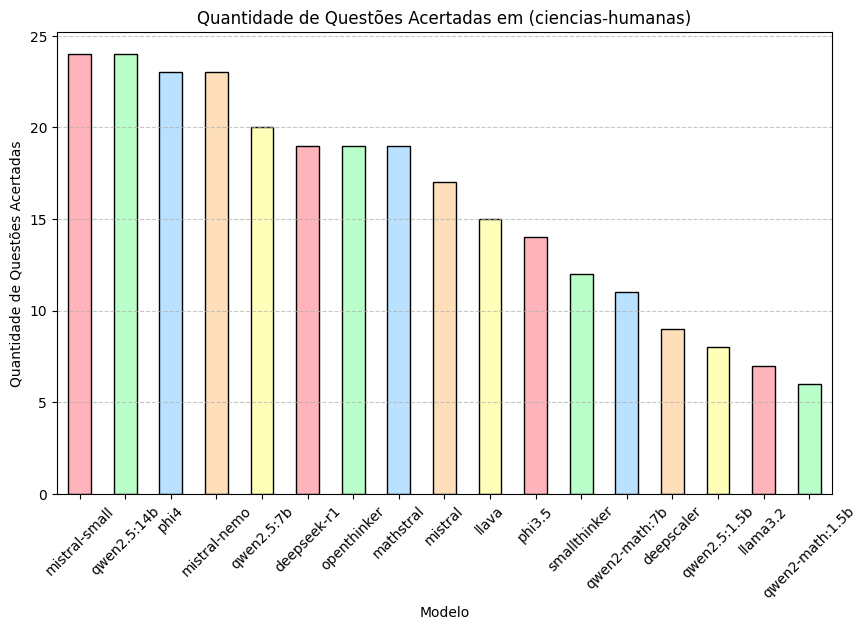

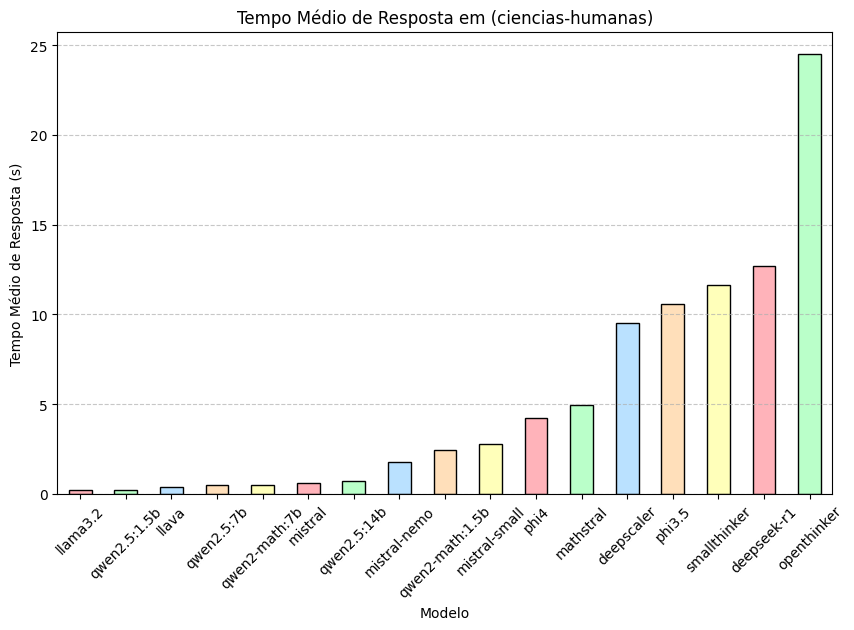

In [21]:
plots.discipline_models(text_table, 'ciencias-humanas', 'acc')
plots.discipline_models(text_table, 'ciencias-humanas', 'time')
None

#### 2.5.3 - Desempenho em Linguagens

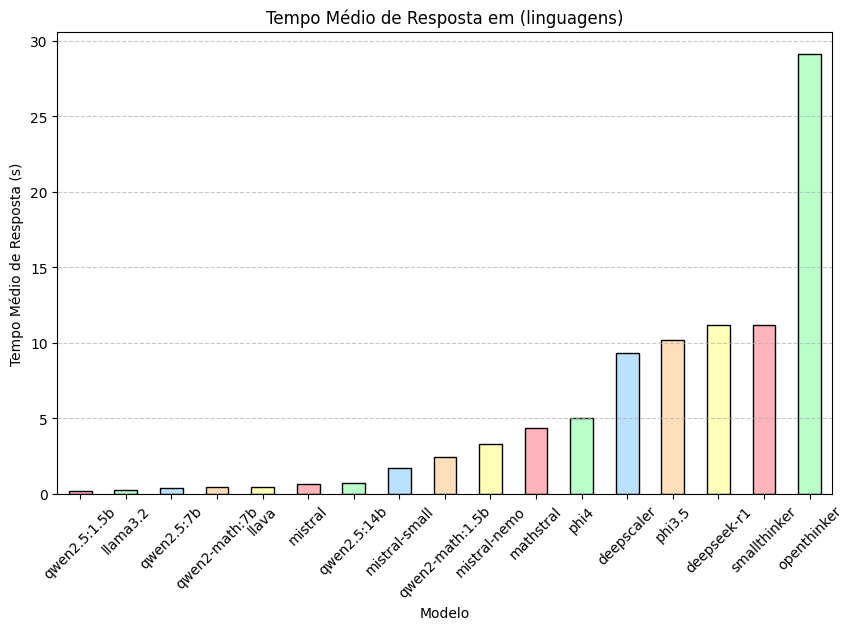

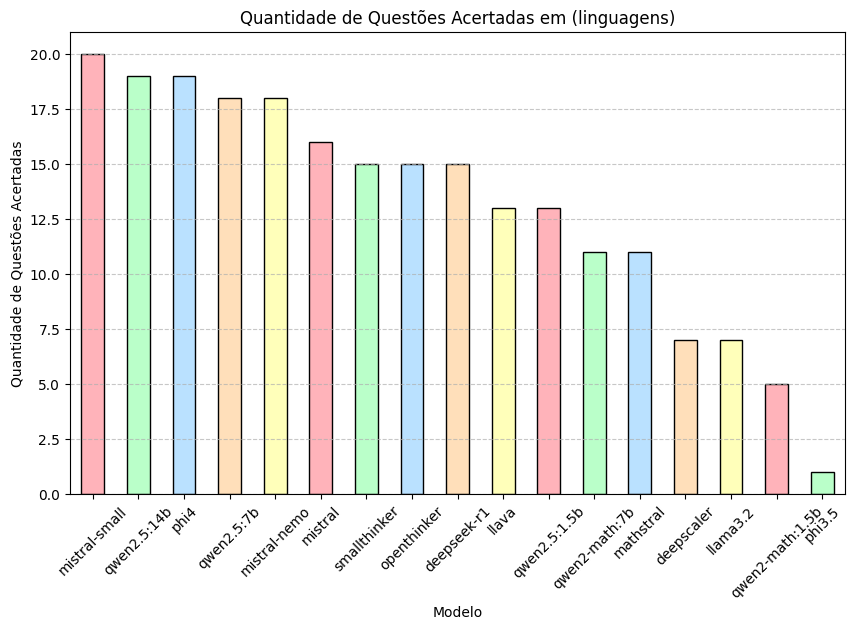

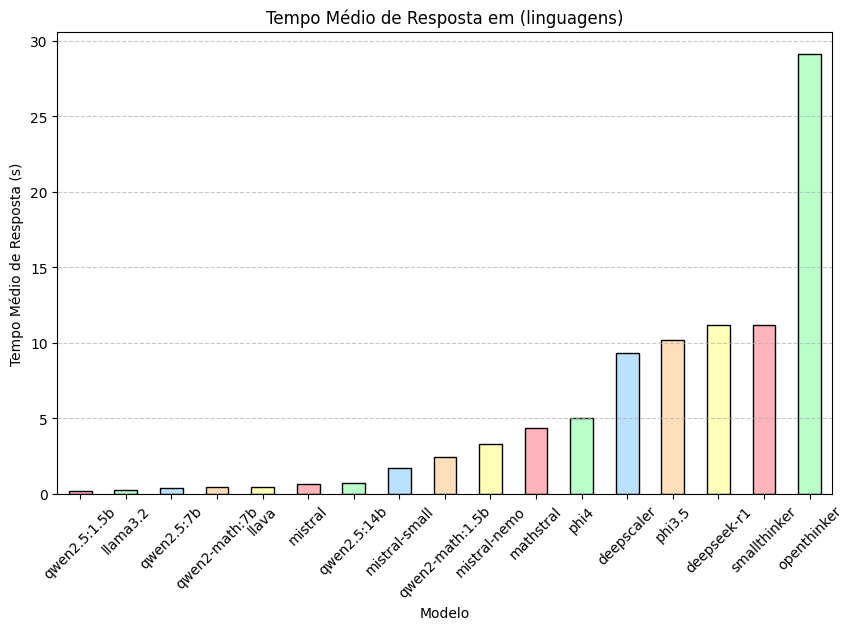

In [20]:
plots.discipline_models(text_table, 'linguagens', 'acc')
plots.discipline_models(text_table, 'linguagens', 'time')
None

O desempenho dos modelos na disciplina de **Linguagens** foi inferior ao de Ciências Humanas, registrando uma **acurácia média de 55,8%**. Apesar disso, foi uma das **melhores métricas entre todas as disciplinas avaliadas**, superando, por exemplo, Matemática e Ciências da Natureza.  

Acreditamos que essa diferença de desempenho em relação a Ciências Humanas pode estar associada à **necessidade de interpretação mais complexa** das questões. Enquanto muitas perguntas em Ciências Humanas possuem **respostas factuais mais objetivas**, as questões de Linguagens frequentemente exigem **análise contextual, compreensão de nuances textuais e inferências**, aspectos que podem representar um desafio adicional para os modelos testados.  

Mesmo com uma média relativamente inferior, **alguns modelos demonstraram desempenho satisfatório**. Apenas **um modelo** conseguiu acertar **mais de 20 questões**, mas **12 modelos** atingiram **15 ou mais acertos**, o que representa um resultado bastante positivo. Esse desempenho sugere que, embora a disciplina de Linguagens represente um desafio maior em termos de interpretação, **boa parte dos modelos ainda conseguiu alcançar uma performance sólida**, demonstrando certo nível de capacidade de compreensão textual.

#### 2.5.4 Ciências da Natureza

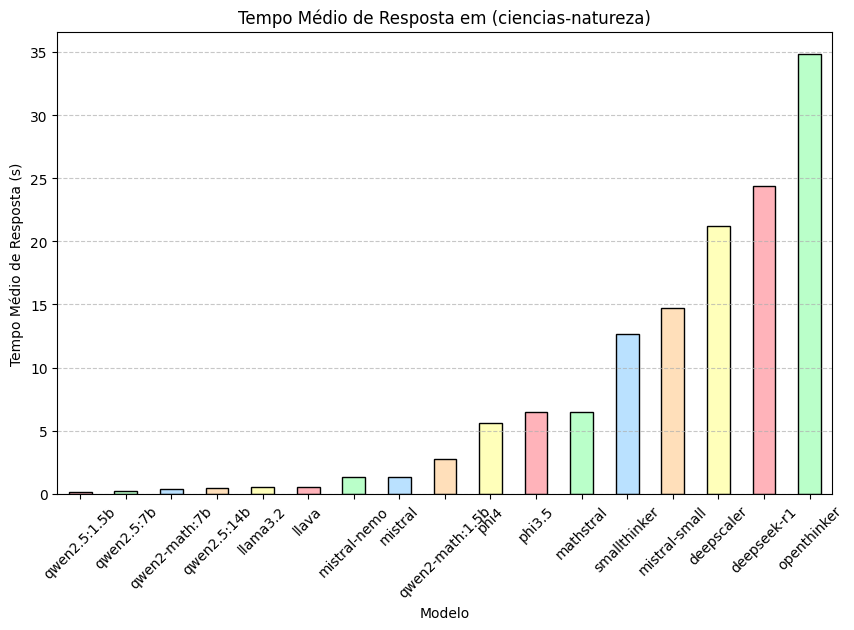

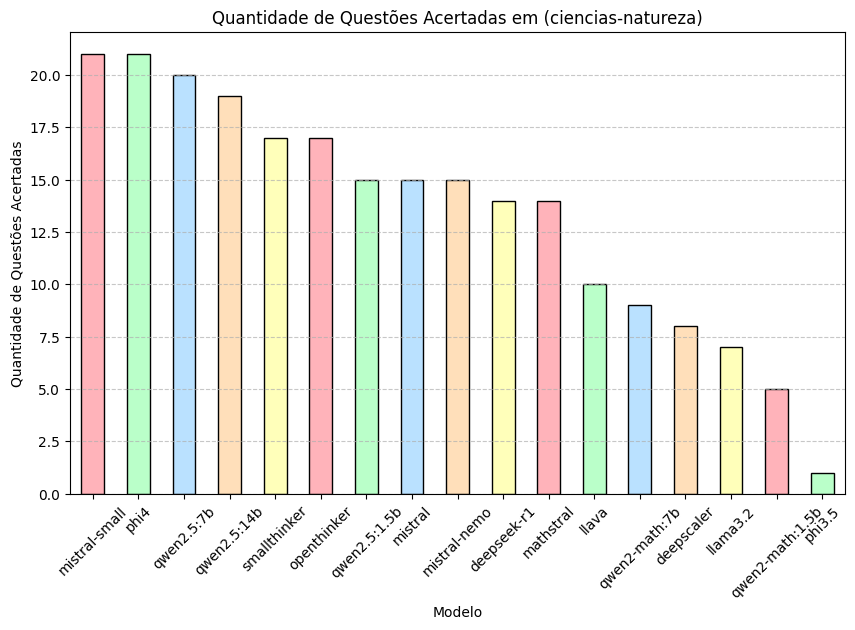

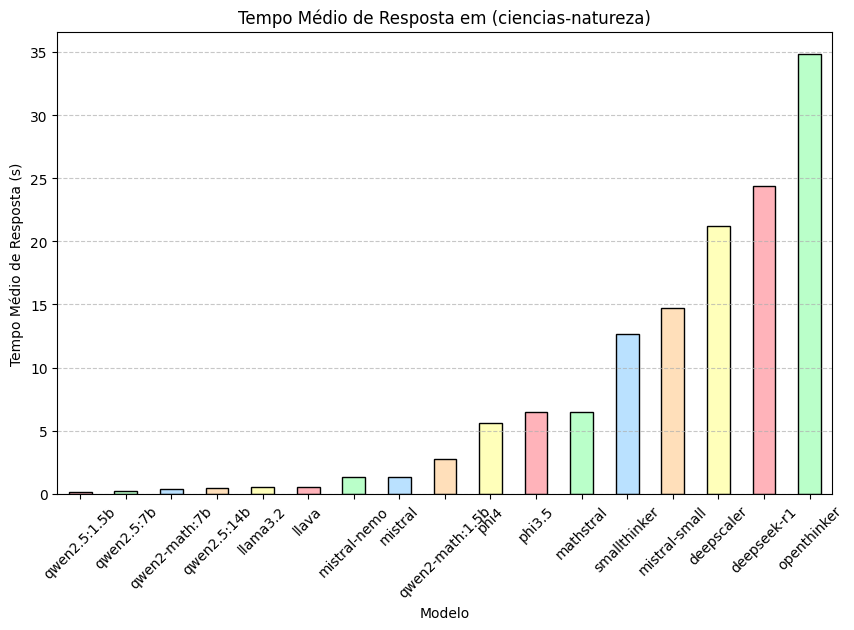

In [22]:
plots.discipline_models(text_table, 'ciencias-natureza', 'acc')
plots.discipline_models(text_table, 'ciencias-natureza', 'time')

A disciplina de Ciências da Natureza apresentou um desempenho próximo ao observado em Linguagens, tanto em relação à acurácia quanto ao tempo de inferência. No entanto, ao analisarmos a variação de tempo entre os modelos testados, nota-se que a escala de crescimento do tempo de inferência foi exponencialmente inferior à observada em Matemática, sugerindo que a complexidade das questões não gerou um impacto tão significativo no processamento dos modelos. Em termos médios, os modelos levaram aproximadamente dez segundos a mais para responder às questões dessa disciplina quando comparados a Linguagens, enquanto a acurácia média se mostrou apenas um ponto percentual superior.  

Esse comportamento já era, de certa forma, esperado, uma vez que muitas questões de Ciências da Natureza exigem conhecimento prévio de conceitos específicos, assim como ocorre em Ciências Humanas. Entretanto, diferentemente dessa última, a disciplina incorpora um número significativo de questões que demandam cálculos, aproximando-se, em parte, das exigências matemáticas. Em Física, por exemplo, modelos precisaram lidar com questões relacionadas às leis de Newton e fenômenos ondulatórios, enquanto em Química foram exigidos cálculos estequiométricos e proporções entre reagentes. Até mesmo em Biologia, verificou-se a necessidade de operações numéricas, como cálculos de porcentagens em genética e estatísticas populacionais.  

Dessa forma, os resultados indicam que Ciências da Natureza pode ser caracterizada como uma disciplina híbrida, combinando elementos de interpretação conceitual e resolução de problemas quantitativos. No entanto, ao considerar o tempo de inferência e a taxa de acertos, observa-se que o comportamento dos modelos nessa disciplina se assemelha mais ao das demais áreas do conhecimento do que ao da Matemática, na qual a escalada do tempo de execução se mostrou muito mais acentuada.  


### 2.6 - Resultados por Questões  

Nesta seção, analisamos o desempenho dos modelos sob a ótica das questões individuais, observando a distribuição de acertos e o tempo de inferência médio por questão.  

Inicialmente, ao considerarmos a distribuição de acertos, observamos que, em média, uma questão foi respondida corretamente por **8,48 modelos**, enquanto a mediana situa-se entre **9 e 15 modelos**. A questão com maior número de acertos foi corretamente respondida por  **16 modelos diferentes**, evidenciando que algumas perguntas são resolvidas com alto grau de consistência entre os modelos. Um aspecto interessante é que **não houve nenhuma questão que não tenha sido corretamente respondida por pelo menos um modelo**, conforme ilustrado na distribuição do histograma abaixo. Como pode ser observado, as duas questões com **menor número de acertos** foram resolvidas corretamente por apenas **dois modelos**.  

A análise desse histograma revela um comportamento que **se aproxima de uma distribuição normal**, com maior concentração de frequência na região central da curva e menor nas extremidades. No entanto, nota-se uma assimetria pontual, especialmente na **categoria de acertos igual a 4**, que apresentou uma frequência superior à categoria seguinte, o que indica uma leve irregularidade na distribuição dos acertos.  

In [47]:
table_question = lib.utils.analisar_tabela(text_table, 'question')
table_question = table_question[table_question['Total'] > 10]
display(table_question[['OK', 'Tavg']].describe())
(table_question['OK'] == 0.0).sum(), (table_question['OK'] == 16.0).sum()

,OK,Tavg
count,100.000000,100.000000
mean,9.160000,9.322356
std,3.915058,8.735102
min,1.000000,2.738627
25%,6.000000,4.309601
50%,9.000000,5.408893
75%,12.000000,10.669667
max,16.000000,45.102289


(np.int64(0), np.int64(5))

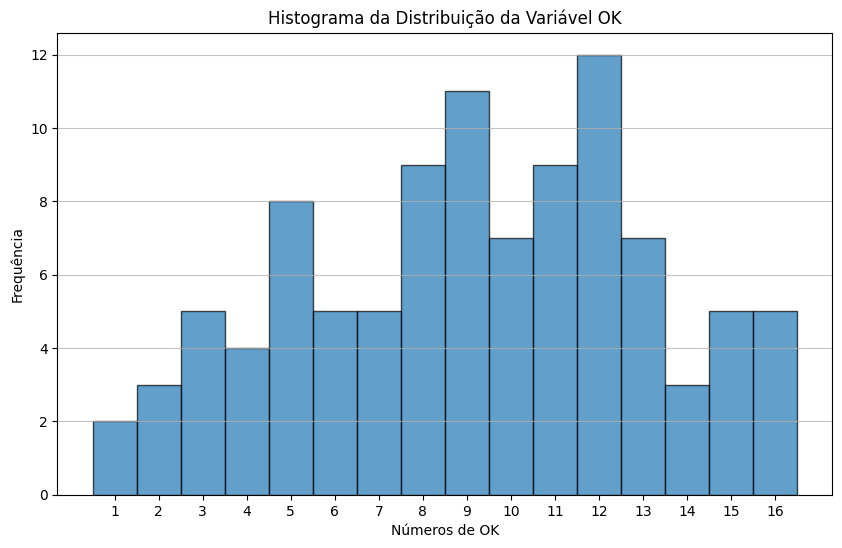

In [ ]:
plots.histogram(table_question, 'OK', 100);

Por outro lado, ao analisarmos a distribuição do tempo médio de inferência por questão, observamos um padrão **exponencial**, no qual os tempos mais baixos representam a maior parte da distribuição. A mediana situa-se em **5,4 segundos**, com a média em **9,3 segundos** e o terceiro quartil em **10,66 segundos**, enquanto o tempo máximo registrado foi de **45 segundos**. Esse comportamento sugere que, na maioria dos casos, os modelos conseguem responder rapidamente às questões, exceto em algumas exceções nas quais o tempo de inferência se eleva consideravelmente. Como analisado anteriormente, essas exceções ocorrem com maior frequência em **questões matemáticas**, que exigem processamento adicional, podendo resultar em tempos significativamente mais elevados.  

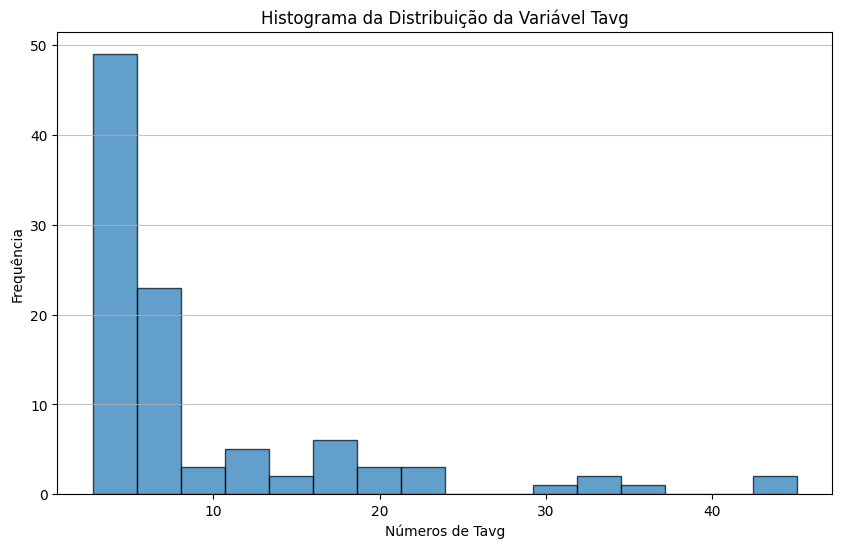

In [59]:

plots.histogram(table_question, 'Tavg');


Para ilustrar melhor esses resultados, a seguir apresentamos exemplos das **questões mais fáceis e mais difíceis**, evidenciando os padrões de acerto e tempo de resposta em diferentes tipos de problemas.  

#### 2.6.1 Questões mais difíceis

As duas questões que tiveram apenas 1 acerto foram uma de Linguagens e outra de Ciências da Natureza, respectivamente dos anos de 2013 e 2018.

In [25]:
(table_question[table_question['OK'] == 1.0])

,question,Total,OK,Null,Err,Tout,Ttot,TTout,Tle,Tavg,Tmax,Tmin
98,2013123,17.0,1.0,1.0,15.0,0.0,77.573042,77.573042,0.0,4.56312,17.146971,0.244754
99,2018134,17.0,1.0,2.0,14.0,0.0,96.506614,96.506614,0.0,5.67686,28.602754,0.095900


##### Questão 2013123 - Linguagens

**Para Carr, internet atua no comércio da distração**

_Autor de “A Geração Superficial” analisa a influência da tecnologia na mente_

O jornalista americano Nicholas Carr acredita que a internet não estimula a inteligência de ninguém. O autor explica descobertas científicas sobre o funcionamento do cérebro humano e teoriza sobre a influência da internet em nossa forma de pensar.  
Para ele, a rede torna o raciocínio de quem navega mais raso, além de fragmentar a atenção de seus usuários.  
Mais: Carr afirma que há empresas obtendo lucro com a recente fragilidade de nossa atenção. “Quanto mais tempo passamos _on-line_ e quanto mais rápido passamos de uma informação para a outra, mais dinheiro as empresas de internet fazem”, avalia.  
“Essas empresas estão no comércio da distração e são _experts_ em nos manter cada vez mais famintos por informação fragmentada em partes pequenas. É claro que elas têm interesse em nos estimular e tirar vantagem da nossa compulsão por tecnologia.”

ROXO, E. **Folha de S. Paulo**, 18 fev. 2012 (adaptado).

(A) : Mantém os usuários cada vez menos preocupados com a qualidade da informação.

(B) : Torna o raciocínio de quem navega mais raso, além de fragmentar a atenção de seus usuários.

(C) : Desestimula a inteligência, de acordo com descobertas científicas sobre o cérebro.

(D) : Influencia nossa forma de pensar com a superficialidade dos meios eletrônicos.

(E) : Garante a empresas a obtenção de mais lucro com a recente fragilidade de nossa atenção.

| **Resposta:** (E)

#### 2.6.2 Questões mais Fáceis

Por fim, tivermos 5 questões com mais respostas corretas, das quais, não houve nenhuma de matemática, porém, em Linguagens tivemos a questão de id **2011109**, em Humanas tivemos as questões **2021090, 2010033, 2023050**, e em Ciências da Natureza tivemos a questão **2021097**. Abaixo demostraremos um exemplo de cada uma dessas disciplinas.

In [46]:
(table_question[table_question['OK'] == 15.0])

,question,Total,OK,Null,Err,Tout,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,2021097,17.0,15.0,1.0,1.0,0.0,60.997539,60.997539,0.0,3.588091,18.385131,0.092390
1,2010033,17.0,15.0,0.0,2.0,0.0,178.785653,178.785653,0.0,10.516803,127.324694,0.108280
2,2023050,17.0,15.0,1.0,1.0,0.0,60.393186,60.393186,0.0,3.552540,13.952859,0.107462
3,2011109,17.0,15.0,1.0,1.0,0.0,84.277090,84.277090,0.0,4.957476,21.555299,0.112088
4,2021090,17.0,15.0,0.0,2.0,0.0,59.041064,59.041064,0.0,3.473004,10.569474,0.188483


##### 2.6.2.1 Questão mais fácil Linguagens

O tema da velhice foi objeto de estudo de brilhantes filósofos ao longo dos tempos. Um dos melhores livros sobre o assunto foi escrito pelo pensador e orador romano Cícero: _A Arte do Envelhecimento_. Cícero nota, primeiramente, que todas as idades têm seus encantos e suas dificuldades. E depois aponta para um paradoxo da humanidade. Todos sonhamos ter uma vida longa, o que significa viver muitos anos. Quando realizamos a meta, em vez de celebrar o feito, nos atiramos a um estado de melancolia e amargura. Ler as palavras de Cícero sobre envelhecimento pode ajudar a aceitar melhor a passagem do tempo.

NOGUEIRA, P. Saúde & Bem-Estar Antienvelhecimento. **Época**. 28 abr. 2008.

(A) : Esclarecer que a velhice é inevitável.

(B) : Contar fatos sobre a arte de envelhecer.

(C) : Defender a ideia de que a velhice é desagradável.

(D) : Influenciar o leitor para que lute contra o envelhecimento.

(E) : Mostrar às pessoas que é possível aceitar, sem angústia, o envelhecimento.

| Resposta: E

##### 2.6.2.1 Questão mais fácil Humanas

EIGENHEER, E. M. **Lixo:** a limpeza urbana através dos tempos. Porto Alegre: Gráfica Palloti, 2009.

**Texto II**  
A repugnante tarefa de carregar lixo e os dejetos da casa para as praças e praias era geralmente destinada ao único escravo da família ou ao de menor status ou valor. Todas as noites, depois das dez horas, os escravos conhecidos popularmente como “tigres” levavam tubos ou barris de excremento e lixo sobre a cabeça pelas ruas do Rio.

KARACH, M. C. **A vida dos escravos no Rio de Janeiro, 1808-1850.** Rio de Janeiro: Cia. das letras, 2000.
(A) : Valorização do trabalho braçal.

(B) : Reiteração das hierarquias sociais.

(C) : Sacralização das atividades laborais.

(D) : Superação das exclusões econômicas.

(E) : Ressignificação das heranças religiosas.

| Resposta: B

##### 2.6.2.2 Questão mais fácil Natureza

EIGENHEER, E. M. **Lixo:** a limpeza urbana através dos tempos. Porto Alegre: Gráfica Palloti, 2009.

**Texto II**  
A repugnante tarefa de carregar lixo e os dejetos da casa para as praças e praias era geralmente destinada ao único escravo da família ou ao de menor status ou valor. Todas as noites, depois das dez horas, os escravos conhecidos popularmente como “tigres” levavam tubos ou barris de excremento e lixo sobre a cabeça pelas ruas do Rio.

KARACH, M. C. **A vida dos escravos no Rio de Janeiro, 1808-1850.** Rio de Janeiro: Cia. das letras, 2000.
(A) : Valorização do trabalho braçal.

(B) : Reiteração das hierarquias sociais.

(C) : Sacralização das atividades laborais.

(D) : Superação das exclusões econômicas.

(E) : Ressignificação das heranças religiosas.

| Resposta: B

### 2.7 - Conclusão

A partir dos experimentos conduzidos, foi possível obter uma visão detalhada sobre o desempenho de diferentes modelos de linguagem na resolução de questões de múltipla escolha, abrangendo diversos aspectos como **acurácia geral, tempo de inferência, desempenho por disciplina e comportamento frente a diferentes tipos de tarefas**. Os resultados indicam que **o número de parâmetros nem sempre é o principal fator determinante da performance**, visto que **modelos intermediários apresentaram desempenhos comparáveis a modelos robustos**, enquanto modelos especializados nem sempre demonstraram superioridade nas áreas para as quais foram ajustados.  

Na análise do impacto do **tamanho do modelo**, observamos que, enquanto modelos menores apresentaram quedas significativas na acurácia, a diferença entre modelos intermediários e robustos foi **mínima ou inexistente**. Em alguns casos, como no **Gemma2**, a versão intermediária obteve tempos de inferência menores sem perda expressiva de precisão, sugerindo que **há um ponto de equilíbrio entre eficiência computacional e desempenho**.  

O **tempo de inferência** demonstrou ser um fator crítico, especialmente em modelos **de reasoning e matemática**, que frequentemente apresentaram tempos muito superiores aos modelos convencionais. O **Openthinker**, por exemplo, chegou a ultrapassar **1h24min** de execução para 100 questões, enquanto os demais modelos raramente ultrapassaram **15 minutos**. Em Matemática, a **demanda computacional** foi um grande desafio, com algumas questões exigindo **até 542 segundos** para serem resolvidas, um valor muito superior ao de qualquer outra disciplina.  

A análise **por disciplina** revelou padrões interessantes. **Ciências Humanas e Linguagens** foram as áreas de maior acurácia, com **67% e 55,8% de precisão média**, respectivamente. O desempenho superior em Ciências Humanas pode estar relacionado ao fato de que muitas questões exigem respostas mais **diretas e factuais**, reduzindo a necessidade de **interpretação subjetiva**. Já em Linguagens, a exigência de **análise contextual** e inferências mais complexas pode ter dificultado a obtenção de acertos. **Ciências da Natureza**, por sua vez, apresentou um comportamento híbrido, combinando aspectos de interpretação conceitual com questões que exigiam cálculos.  

A **Matemática**, como esperado, foi a disciplina de maior dificuldade, tanto em acurácia quanto em tempo de inferência. Apenas **quatro modelos** conseguiram acertar mais da metade das questões matemáticas, e o tempo médio de resposta foi **mais que o dobro** das demais disciplinas. Mesmo os modelos especializados em matemática não demonstraram ganhos significativos de desempenho na área, com exceção do **Mathstral**, que superou o Mistral padrão em um fator de **4x**, evidenciando o impacto positivo do fine-tuning.  

Quando analisamos **o desempenho por questão**, verificamos que **nenhuma questão foi completamente ignorada por todos os modelos**, o que indica um nível mínimo de compreensão em todas as áreas avaliadas. No entanto, houve uma clara distinção entre questões **fáceis e difíceis**, com algumas sendo acertadas por **mais de 15 modelos** e outras por **apenas dois modelos**. O histograma das respostas revelou uma **distribuição próxima da normalidade**, embora com algumas irregularidades, o que pode indicar que certos tipos de perguntas são consistentemente mais desafiadores para os modelos.  

Os resultados estatísticos reforçaram essas observações. O **teste t de Student** não encontrou **diferença significativa** entre modelos intermediários e robustos, sugerindo que modelos menores podem ser opções viáveis em determinados contextos. No entanto, o **teste de equivalência (TOST)** não foi capaz de confirmar que os modelos estão dentro de um intervalo de tolerância de **±2%**, o que impede uma conclusão definitiva sobre a equivalência entre categorias de modelos.  

Diante desses resultados, podemos concluir que **a escolha do modelo ideal deve levar em consideração múltiplos fatores além da acurácia bruta**, incluindo **tempo de inferência, consumo computacional, estabilidade das respostas e adequação às tarefas específicas**. Modelos robustos podem ser necessários para cenários que demandam **maior precisão**, mas modelos intermediários demonstraram **eficiência suficiente** para grande parte das tarefas. Além disso, a dificuldade que os modelos enfrentaram com **questões matemáticas** reforça a necessidade de avanços na capacidade de raciocínio lógico das arquiteturas atuais.  

Por fim, a análise apresentada destaca **os desafios e limitações das arquiteturas de LLMs atuais**, ao mesmo tempo que aponta caminhos para otimizações futuras, seja na **especialização de modelos para tarefas específicas**, seja no aprimoramento do **balanço entre custo computacional e desempenho**. 

## 3. Questões com Imagens no Contexto

Um grande desafio para as LLM é a interpretação de dados fora do escorpo textual, como por exemplo imagens, mesmo existindo alguns recursos de visão ocupacional, a complexidade de algumas imagens são muito altas, e alinhados com o o desafio de responder questões de prova, nosso objetivo e ainda maior.

O primeiro passo de nosso desafio é analisar as questões que possuem imagens em sua contextualização, porém as respostas estão de forma textual. Esse desafio possui o nível mais baixo entre os de imagens, pois algumas questões conseguem ser respondidas sem a imagem.

### 3.1 Testando Modelos de Visão

Primeiramente iremos testar com alguns modelos voltados para visão computacional, na etapa anterior, chegamos a utilizar o **llava** juntamente com outros modelos, porém tivemos um desempenho bem inferior aos demais modelos testados. 

E para esse teste, iremos utilizar 6 modelos, são eles: **minicpm-v**, **moondream**, o já mencionado **llava**, e mais 2 **fine-tunning** desse modelos, os **llava-phi3**, **llava-llama3**, modelo o qual um mais recente também possui uma variação de visão, o **llama3.2-vision**. Na criação desses testes, esses são os modelos de visão computacional mais recentees no Ollama, mesmo já havendo o **llama3.3**, não há uma variação que possua visão computacional.

Selecionamos todas as questões das provas que possuem essa formatação para esse teste, no total, 795 questões.

In [27]:
visions_models = ["llava", "llama3.2-vision", "llava-llama3", "minicpm-v","moondream", "llava-phi3"]

context_questions = list(filter(lambda x : x["type"] == "context-image", questoes))

# test_result_context_vision = test_models(
#     primary_models= visions_models,
#     questions = context_questions,
# )

vision_models_test_table = lib.utils.test_table(
    models=visions_models,
    questions=context_questions
)

clear_output(wait=True)
display(lib.utils.format_test_table(vision_models_test_table))
plots.model_performance(vision_models_test_table, "Desempenho de Modelos de Visão Computacional")
None

TypeError: 'int' object is not subscriptable

Como esperado, os resultados dos testes com imagens forma muito abaixo do esperado, com um modelo conseguindo acertar apenas 8 questões, e o modelo com maior acurácia conseguiu apenas 35.7% de acurácia. O **lava** que verificamos na etapa anterior reduziu metade de sua acurácia, chegando a apenas 19.4%, em contraste aos 40% do teste anterior, número esse que é superior ao melhor modelo de visão nesse teste.

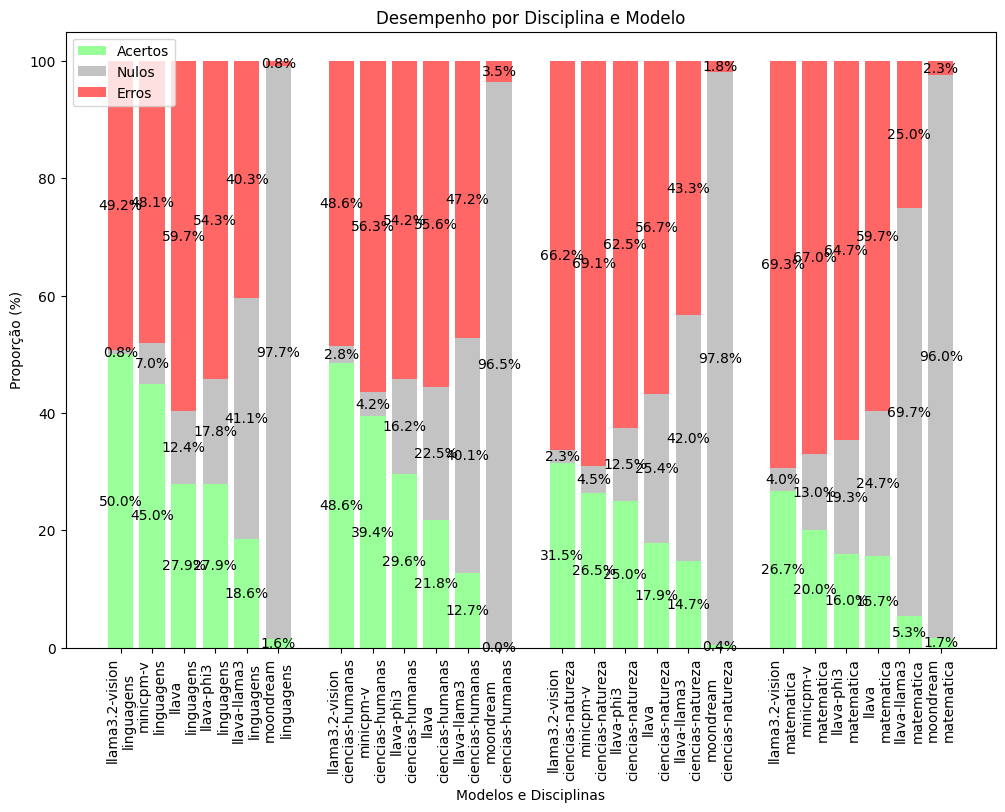

In [ ]:
plots.discipline_performance(visions_models, context_questions, normalize=True)
None

Observando o desempenho por disciplina, é como se o desempenho fosse reduzido pela metade em comparação com as questões de apenas texto, porém a discrepância das disciplinas forma bem inferiores à discrepância anterior, uma vez que houve uma dificuldade em todas as questões.

### 3.2 Mesclando Modelos

Uma ideia que tivemos é tentar juntar dois modelos para tentarmos ter uma acurácia melhor, para isso nós selecionamos os melhores modelos que tivemos na etapa 2, e juntamos com todos os modelos de visão computacional, na qual o sistema funciona da seguinte maneira:

graph TD
    A[Questão com Imagem] -->|Envia Imagem| B[Modelo de Visão]
    B -->|Retorna Descrição da Imagem| C[Descrição da Imagem]
    C -->|Combina com Questão| D[Questão Completa]
    D -->|Envia para Modelo 2| E[Modelo Textual]
    E -->|Retorna Resposta| F[Resposta Final]


Ou seja, primeiramente pedimos a descrição da imagem ao modelo de visão, a partir de sua descrição, integramos a descrição na questão, e enviamos para o modelo de texto. Por fim, o modelo de texto retorna a resposta final.

Primeiramente tinhamos selecionado 25 questões de cada disciplina, de forma bastante similar como foi feito nos testes de texto, porém, com a junção de dois modelos, o tempo de execuçõ dos modelos, subiu muito, e tivemos que reduzir para 10 questões de cada disciplina.

,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,minicpm-v+phi4,14.6,40 (53.3%),27,0,13,0,0.675000,15:06,45:06,04:45:11,22.66,40.36,9.49
1,llama3.2-vision+phi4,17.0,40 (53.3%),24,0,16,0,0.600000,23:29,38:29,07:23:30,35.25,55.78,11.77
2,llama3.2-vision+mistral-small,21.9,40 (53.3%),22,1,16,1,0.550000,53:05,01:08:05,16:42:06,01:19,02:50,41.08
3,minicpm-v+gemma2,10.9,40 (53.3%),22,0,18,0,0.550000,07:27,37:27,02:20:37,11.18,23.79,7.86
4,moondream+phi4,10.8,40 (53.3%),22,0,18,0,0.550000,10:58,40:58,03:27:02,16.45,31.81,8.58
5,llava-phi3+mistral-small,16.9,40 (53.3%),21,0,19,0,0.525000,35:05,01:05:05,11:02:27,52.65,02:14,14.81
6,moondream+mistral-small,15.7,40 (53.3%),21,0,19,0,0.525000,34:24,01:04:24,10:49:30,51.62,02:01,12.53
7,llava+phi4,13.8,40 (53.3%),21,0,19,0,0.525000,11:53,16:53,03:44:28,17.84,38.28,8.34
8,moondream+gemma2,7.1,40 (53.3%),21,0,19,0,0.525000,04:10,34:10,01:18:54,6.27,11.62,4.95
9,llava-llama3+phi4,14.6,40 (53.3%),21,0,19,0,0.525000,13:28,33:28,04:14:29,20.22,58.21,9.69


count    37.000000
mean      0.445300
std       0.102415
min       0.225000
25%       0.400000
50%       0.475000
75%       0.525000
max       0.675000
Name: Acc, dtype: float64

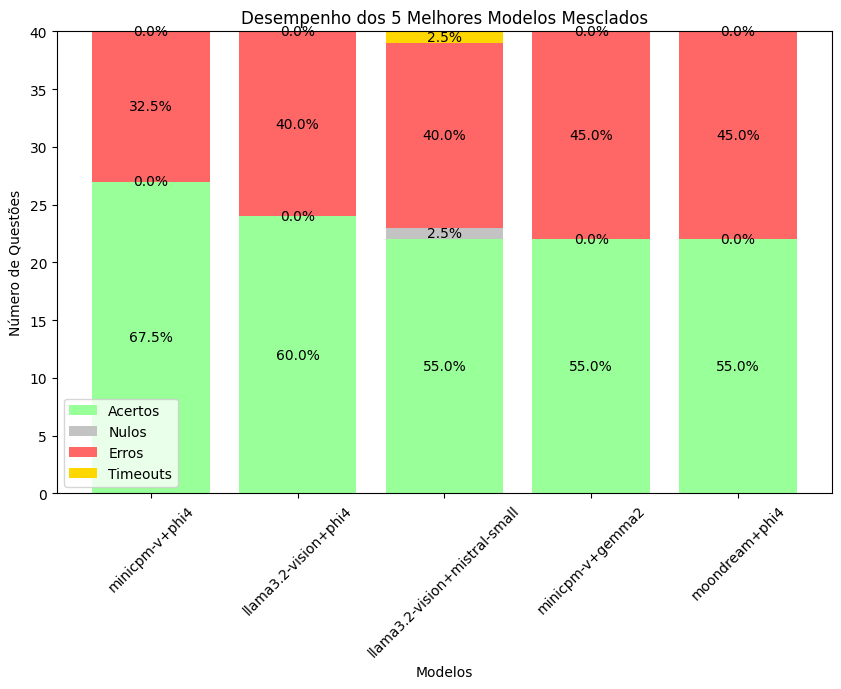

In [ ]:
best_text_models = ["mistral-small", "qwen2.5:7b", "mistral-nemo", "gemma2", "mistral", "phi4"]

example_context_questions = (
    list(random.sample(list(filter(lambda x : x["discipline"] == "ciencias-humanas", context_questions)), 25))[:10] +
    list(random.sample(list(filter(lambda x : x["discipline"] == "ciencias-natureza", context_questions)),25))[:10] +
    list(random.sample(list(filter(lambda x : x["discipline"] == "linguagens", context_questions)),25))[:10] +
    list(random.sample(list(filter(lambda x : x["discipline"] == "matematica", context_questions)),25))[:10]
)

# mix_models_context_result = test_models(
#     primary_models=best_text_models,
#     secundary_models=visions_models,
#     questions=example_context_questions
# )

mix_models_test_table = lib.utils.test_table(
    models=lib.utils.gen_modelos_str(primary_models=best_text_models, secundary_models=visions_models),
    questions=context_questions
)

clear_output(wait=True)
display(lib.utils.format_test_table(mix_models_test_table))
plots.model_performance(mix_models_test_table.head(5), "Desempenho dos 5 Melhores Modelos Mesclados")

mix_models_test_table["Acc"].describe()

Em geral tivemos um desempenho muito superior ao teste com apenas modelos de visão computacional, com o 25% chegando a uma acurácia de 40. Em geral, não houve uma variação muito grande nos resultados, e a acurácia máxima que chegamos foi de 67.5%.

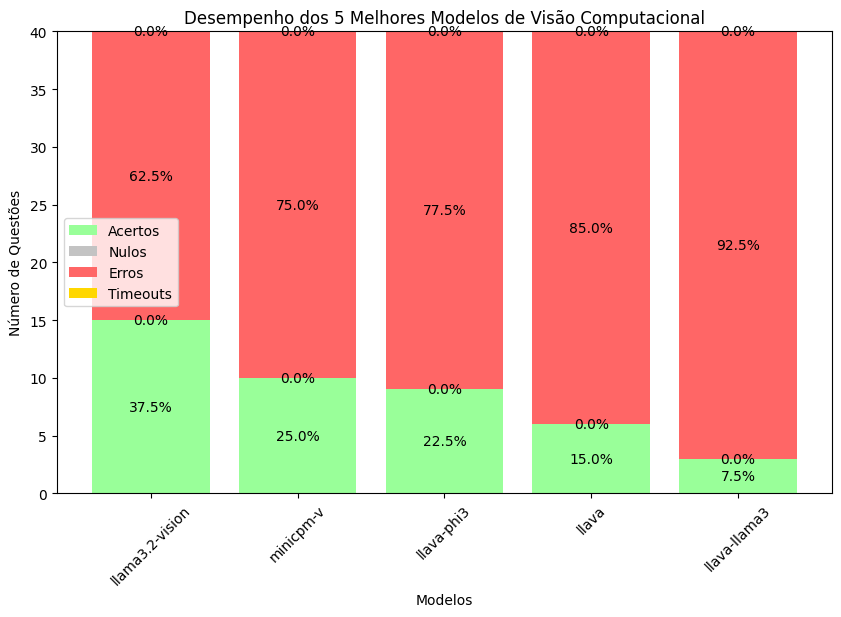

In [ ]:
vision_models_test_table_example = lib.utils.test_table(
    models=visions_models,
    questions=example_context_questions
)
plots.model_performance(vision_models_test_table_example.head(5), "Desempenho dos 5 Melhores Modelos de Visão Computacional")
None

Comparando as mesmas qustões com os modelos de apenas visão computacional, nota-se que de fato, houve uma melhora significativa.

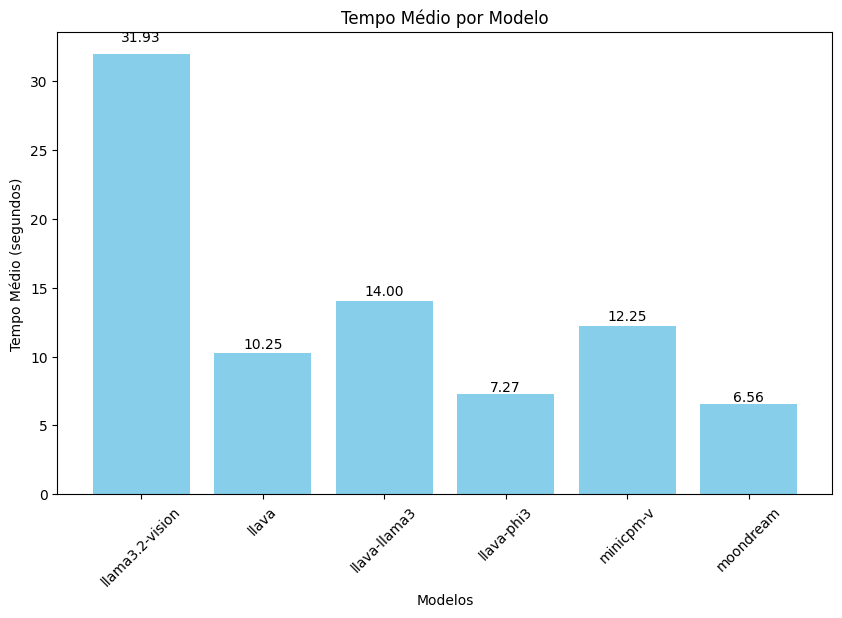

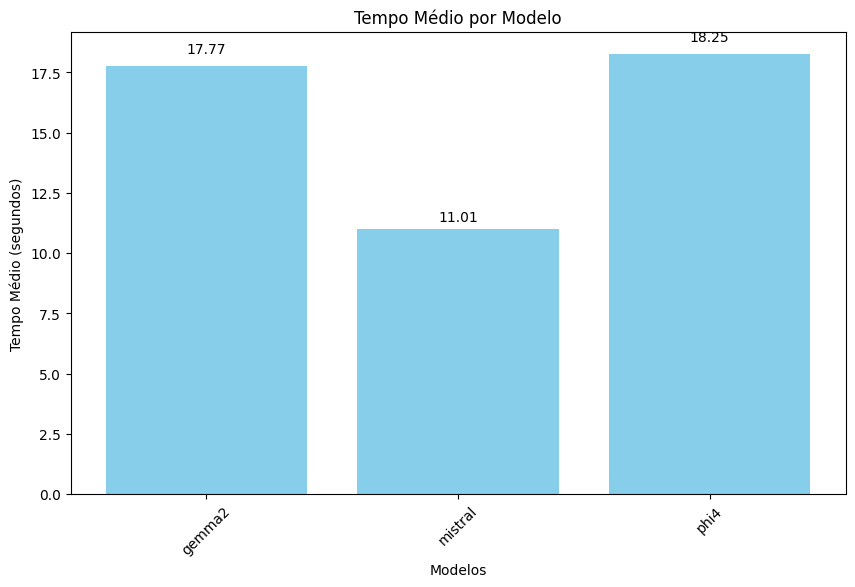

In [ ]:
plots.multi_model_performance(
    group='model_vision',
    y_axis='time-avg',
    questions=example_context_questions,
    vision_models=visions_models,
    text_models=best_text_models
)

plots.multi_model_performance(
    group='model_text',
    y_axis='time-avg',
    questions=example_context_questions,
    vision_models=visions_models,
    text_models=best_text_models
)
#TODO: Ajustar o plot para acurácia e por modelo de textos

None

## 4. Questões com Imagens nas Alternativas

Temos um deafio ainda maior comparado com os anteriores, pois neste novo desafio, as alternativas estarão em formato de imagem, o que exige uma precisão maior de interpretação de como é a imagem, podendo ter questões muito complexa, primeiramente iremos explorar 2 tipos de questões presentes, e depois iremos testar com apenas modelos de visão, depois mesclaremos os modelos.


### 4.1 Exemplo de Questões 

##### Questão 21 da Prova de 2009

Os seres vivos apresentam diferentes ciclos de vida, caracterizados pelas fases nas quais gametas são produzidos e pelos processos reprodutivos que resultam na geração de novos indivíduos.

(A) |![Alternativa A](./questoes/alternative_images\2009021-A.png)

(B) |![Alternativa B](./questoes/alternative_images\2009021-B.png)

(C) |![Alternativa C](./questoes/alternative_images\2009021-C.png)

(D) |![Alternativa D](./questoes/alternative_images\2009021-D.png)

(E) | ![Alternativa E](./questoes/alternative_images\2009021-E.png)

| Resposta: C

Nessa questão notamos que a complexidade para essa questão é compreender o texto e também o diagrama, talvez o maior desafio do modelo é conseguir interpretar o funcionamento do diagrama.

##### Questão 91 da Prova de 2009

Os melhores críticos da cultura brasileira trataram-na sempre no plural, isto é, enfatizando a coexistência no Brasil de diversas culturas. Arthur Ramos distingue as culturas não europeias (indígenas, negras) das europeias (portuguesa, italiana, alemã etc.), e Darcy Ribeiro fala de diversos Brasis: crioulo, caboclo, sertanejo, caipira e de Brasis sulinos, a cada um deles correspondendo uma cultura específica.

MORAIS, F. **O Brasil na visão do artista: o país e sua cultura.**  
São Paulo: Sudameris, 2003.

(A)
![Alternativa A](./questoes/alternative_images\2009091-A.png)

(B)
![Alternativa B](./questoes/alternative_images\2009091-B.png)

(C)
![Alternativa C](./questoes/alternative_images\2009091-C.png)

(D)
![Alternativa D](./questoes/alternative_images\2009091-D.png)

(E)
![Alternativa E](./questoes/alternative_images\2009091-E.png)

| Resposta: A

Essa questão têm uma complexidade de interpretar a imagem, e ainda possui várias imagens abstratas, o que pode impactar significativamente no desempenho dos modelos, esse exemplo é bem mais complexo que o anterior.

### 4.2 Apenas Modelos de Visão

A nível de comparação, novamente iremos utilizar apenas modelos de visão computacional e avaliar o seu desempenho. Para esse teste iremos ter que remover o **ollama3.2-vision**, embora nos testes individuiais foi o melhor modelo, o modelo não suporta mais de uma imagem por requisição.

Nesse teste iremos utilizat todas as questões desse formato, pois temos apenas 61 questões

,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,minicpm-v,5.5,61 (100.0%),6,0,55,0,0.098361,01:58,01:58,0.00,1.94,7.37,1.41
1,moondream,1.7,61 (100.0%),0,0,61,0,0.000000,01:08,01:08,0.00,1.12,4.57,1.02
2,llava-phi3,2.9,61 (100.0%),0,0,61,0,0.000000,03:06,03:06,0.00,3.06,11.77,2.12
3,TOTAL,10.1,183 (100.0%),6,0,177,0,0.032787,06:13,0.00,ND,2.04,11.77,1.02


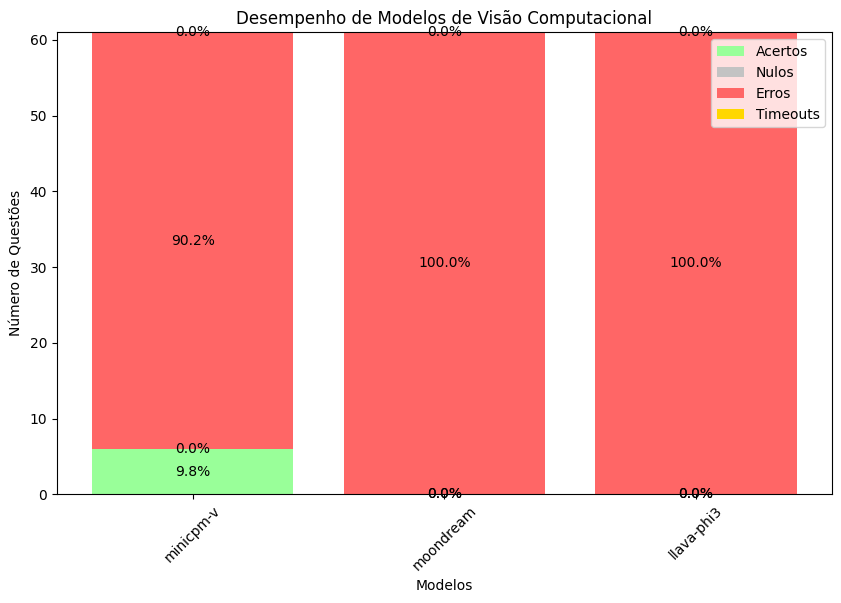

In [ ]:
answer_questions = list(filter(lambda x :x['type'] == 'answer-image', questoes))

# test_models(
#     models = ["moondream", "minicpm-v", "llava-phi3"], # o llama3.2-vision não suporta mais de uma imagem
#     questions = answer_questions,
#     predict_file = "./data/predict_data/answ-vision.json"
# )

answer_questions_table_vision = lib.utils.test_table(
    questions=answer_questions,
    models= ["moondream", "minicpm-v", "llava-phi3"]
)

clear_output(wait=True)
display(lib.utils.format_test_table(answer_questions_table_vision))
plots.model_performance(answer_questions_table_vision, "Desempenho de Modelos de Visão Computacional")
None

Notamos um desempenho ainda mais baixo do que o anterior, com apenas um modelo conseguindo acertar alguma questão, e mesmo assim, não conseguindo uma acurácia de nem 10%, mostrando o quão complexo se tornou esse desafio.

### 4.3 Mistura de Modelos

Então novamente iemos utilizar o recurso que utilizamos na etapa 3, e vamos incluir outro modelo no mesmo esquema de etapa 3.2. Dessa vez iremos utilizar apenas os modelos **phi4** que entregou um melhor resultado, e **gemma2**, que conseguiu entregar um resultado satisfatório, sendo mais leve e mais rápido.


,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,minicpm-v+gemma2,10.9,61 (100.0%),14,0,47,0,0.229508,01:45,01:45,0.00,1.72,8.52,0.27
1,llama3.2-vision+gemma2,13.3,61 (100.0%),11,0,50,0,0.180328,01:41,01:41,0.00,1.67,9.11,0.27
2,minicpm-v+phi4,14.6,61 (100.0%),11,0,50,0,0.180328,10:31,10:31,0.00,10.35,25.40,2.12
3,moondream+gemma2,7.1,61 (100.0%),11,0,50,0,0.180328,01:57,01:57,0.00,1.93,8.81,0.27
4,moondream+phi4,10.8,61 (100.0%),10,0,51,0,0.163934,10:52,10:52,0.00,10.69,25.77,2.56
5,llama3.2-vision+phi4,17.0,61 (100.0%),9,0,52,0,0.147541,11:17,11:17,0.00,11.10,26.76,2.26
6,TOTAL,73.7,366 (100.0%),66,0,300,0,0.180328,38:05,0.00,ND,6.24,26.76,0.27


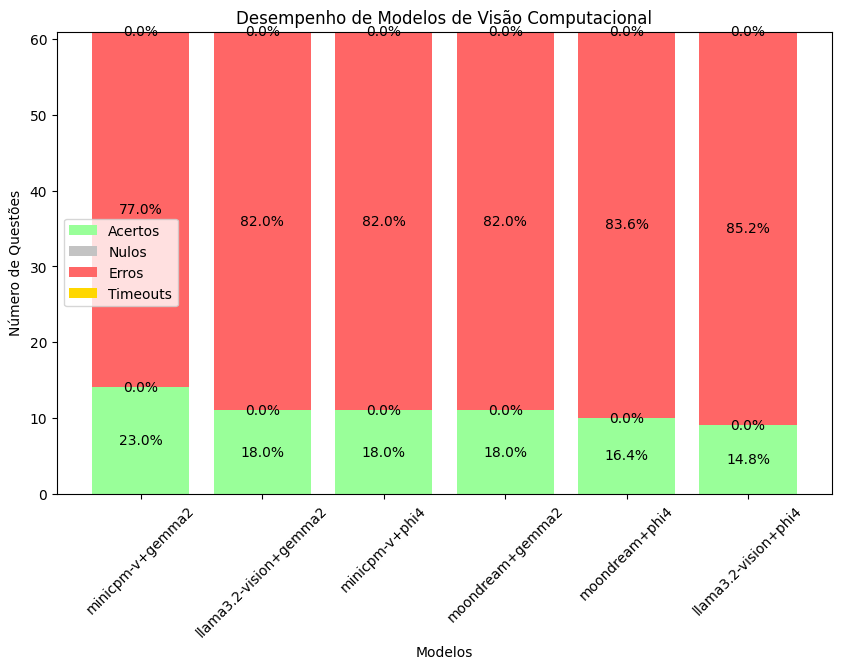

In [ ]:

# test_models(
#     primary_models = ['phi4', 'gemma2'],
#     secundary_models= ["llama3.2-vision", "moondream", "minicpm-v"],
#     questions=answer_questions,
# )

answer_questions_table_mix = lib.utils.test_table(
    questions=answer_questions,
    models= lib.utils.gen_modelos_str(
        primary_models= ['phi4', 'gemma2'], 
        secundary_models= ["llama3.2-vision", "moondream", "minicpm-v"]
    )
)


clear_output(wait=True)
display(lib.utils.format_test_table(answer_questions_table_mix))
plots.model_performance(answer_questions_table_mix, "Desempenho de Modelos de Visão Computacional")
None

Conseguimos um desempenho maior, porém baixo, não chegando a nem 23% no melhor caso, a questão que apresentamos, por exemplo, nenhum modelo conseguiu, nem mesmo mesclando os modelos, eles forma capazes de acertar essa questão.

## 5. Questões com imagens no contexto e nas alternativas

Por fim, nosso último desafio, o mais complexo deles, agora devemos interpretar a imagem e as alternativas. A expectativa que tenhamos um resultado ainda mais baixo que que a forma anterior, que já foi extremamente baixa.


### 5.1 Exemplo de Questões Full-Image


Em Florença, Itália, na Igreja de Santa Croce, é possível encontrar um portão em que aparecem os anéis de Borromeo. Alguns historiadores acreditavam que os círculos representavam as três artes: escultura, pintura e arquitetura, pois elas eram tão próximas quanto inseparáveis.

![Imagem Contexto](../data/questoes/context_images/2009149.jpg)

(A)
![Alternativa A](../data/questoes/alternative_images/2009149-A.jpg)

(B)
![Alternativa B](../data/questoes/alternative_images/2009149-B.jpg)

(C)
![Alternativa C](../data/questoes/alternative_images/2009149-C.jpg)

(D)
![Alternativa D](../data/questoes/alternative_images/2009149-D.jpg)

(E)
![Alternativa E](../data/questoes/alternative_images/2009149-E.jpg)

| Resposta: E

### 5.2 Modelos de Visão

,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,minicpm-v,5.5,61 (100.0%),6,0,55,0,0.098361,01:58,01:58,0.00,1.94,7.37,1.41
1,moondream,1.7,61 (100.0%),0,0,61,0,0.000000,01:08,01:08,0.00,1.12,4.57,1.02
2,llava-phi3,2.9,61 (100.0%),0,0,61,0,0.000000,03:06,03:06,0.00,3.06,11.77,2.12
3,TOTAL,10.1,183 (100.0%),6,0,177,0,0.032787,06:13,0.00,ND,2.04,11.77,1.02


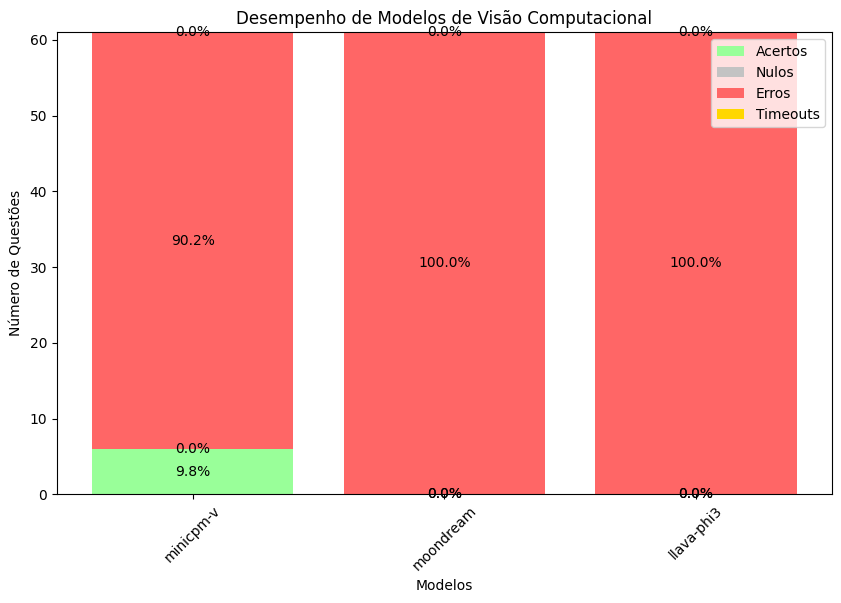

In [ ]:
full_image_questions = list(filter(lambda x :x['type'] == 'full-image', questoes))

full_questions_table_vision = lib.utils.test_table(
    questions=answer_questions,
    models= ["moondream", "minicpm-v", "llava-phi3"]
)

clear_output(wait=True)
display(lib.utils.format_test_table(full_questions_table_vision))
plots.model_performance(full_questions_table_vision, "Desempenho de Modelos de Visão Computacional")
None

### 5.3 Modelos Combinados

,Model,Size,Finish,OK,Null,Err,Tout,Acc,Ttot,TTout,Tle,Tavg,Tmax,Tmin
0,minicpm-v+gemma2,10.9,61 (100.0%),14,0,47,0,0.229508,01:45,01:45,0.00,1.72,8.52,0.27
1,llama3.2-vision+gemma2,13.3,61 (100.0%),11,0,50,0,0.180328,01:41,01:41,0.00,1.67,9.11,0.27
2,minicpm-v+phi4,14.6,61 (100.0%),11,0,50,0,0.180328,10:31,10:31,0.00,10.35,25.40,2.12
3,moondream+gemma2,7.1,61 (100.0%),11,0,50,0,0.180328,01:57,01:57,0.00,1.93,8.81,0.27
4,moondream+phi4,10.8,61 (100.0%),10,0,51,0,0.163934,10:52,10:52,0.00,10.69,25.77,2.56
5,llama3.2-vision+phi4,17.0,61 (100.0%),9,0,52,0,0.147541,11:17,11:17,0.00,11.10,26.76,2.26
6,TOTAL,73.7,366 (100.0%),66,0,300,0,0.180328,38:05,0.00,ND,6.24,26.76,0.27


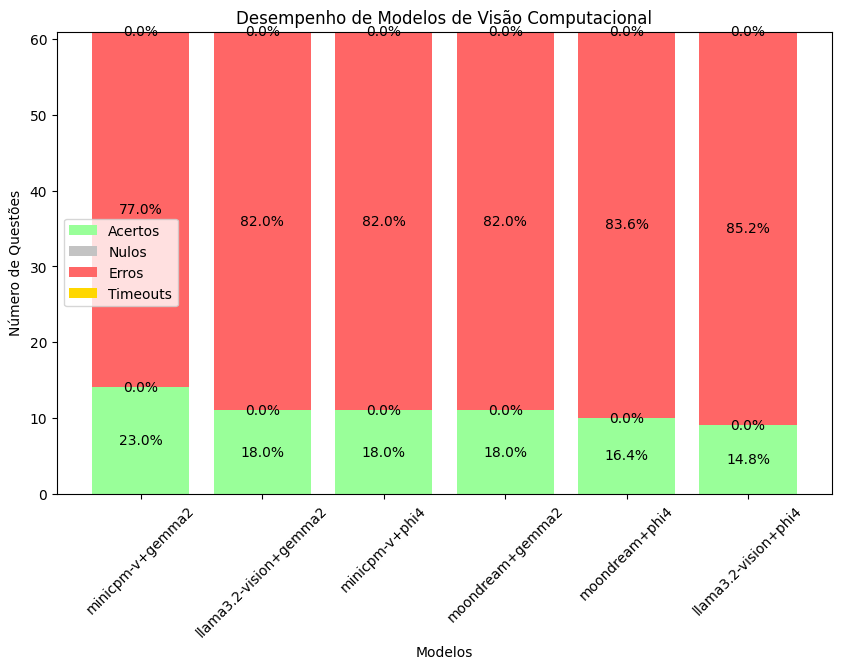

In [ ]:
full_questions_table_mix = lib.utils.test_table(
    questions=answer_questions,
    models= lib.utils.gen_modelos_str(
        primary_models= ['phi4', 'gemma2'], 
        secundary_models= ["llama3.2-vision", "moondream", "minicpm-v"]
    )
)

clear_output(wait=True)
display(lib.utils.format_test_table(full_questions_table_mix))
plots.model_performance(full_questions_table_mix, "Desempenho de Modelos de Visão Computacional")
None